# Rebuild the full GP pipeline using the stable SOS bandpass filter, then run the full visualization.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt, welch
from scipy.interpolate import PchipInterpolator
import pywt
from numpy import trapezoid as _trapz
from scipy.stats import linregress
from scipy.signal import hilbert

In [ ]:
# ===================== Core helpers =====================

def bandpass_wide(x, Fs, lo=5.0, hi=40.0, order=8):
    nyq = 0.5 * Fs
    sos = butter(order, [lo/nyq, hi/nyq], btype='bandpass', output='sos')
    return sosfiltfilt(sos, x)

def analytic_signal_fft(x):
    x = np.asarray(x)
    n = x.size
    X = np.fft.fft(x, n)
    h = np.zeros(n)
    if n % 2 == 0:
        h[0] = 1.0; h[n//2] = 1.0; h[1:n//2] = 2.0
    else:
        h[0] = 1.0; h[1:(n+1)//2] = 2.0
    return np.fft.ifft(X * h)

def rewrap(phi):
    return (phi + np.pi) % (2*np.pi) - np.pi

def inst_freq_from_phase(phi, Fs):
    dphi = np.diff(phi)
    dphi = (dphi + np.pi) % (2*np.pi) - np.pi
    ifreq = (dphi / (2*np.pi)) * Fs
    return np.concatenate([ifreq, [np.nan]])

def repair_phase_with_pchip(phi_wrapped, bad_mask):
    phi = np.unwrap(phi_wrapped)
    phi_interp = phi.copy()
    phi_interp[bad_mask] = np.nan
    valid = ~np.isnan(phi_interp)
    if valid.sum() >= 2:
        xs = np.flatnonzero(valid); ys = phi_interp[valid]
        pchip = PchipInterpolator(xs, ys, extrapolate=False)
        phi_interp[~valid] = pchip(np.flatnonzero(~valid))
    return rewrap(phi_interp), phi_interp

# ---- shared utilities ----

def _weighted_phase_slope(tt, ph, wt):
    wt = np.asarray(wt, float); tt = np.asarray(tt, float); ph = np.asarray(ph, float)
    W = wt + 1e-12; wsum = np.sum(W)
    tbar = np.sum(W * tt) / wsum; pbar = np.sum(W * ph) / wsum
    num = np.sum(W * (tt - tbar) * (ph - pbar))
    den = np.sum(W * (tt - tbar)**2) + 1e-18
    w_hat = num / den; b_hat = pbar - w_hat * tbar
    return w_hat, b_hat

def _circular_R(residuals, wt=None):
    z = np.exp(1j * residuals)
    if wt is None:
        return np.abs(np.nanmean(z))
    w = np.asarray(wt, float)
    return np.abs(np.nansum(w * z) / (np.nansum(w) + 1e-12))

def _contiguous_runs(mask: np.ndarray):
    m = np.asarray(mask, dtype=bool)
    dm = np.diff(m.astype(int), prepend=0, append=0)
    starts = np.flatnonzero(dm == 1); ends = np.flatnonzero(dm == -1)
    return list(zip(starts, ends))  # [start, end)

def _center_to_span_mask(center_mask, windows, centers, n):
    out = np.zeros(n, dtype=bool)
    for (s, e), c in zip(windows, centers):
        if 0 <= c < n and center_mask[c]:
            out[s:e] = True
    return out

def _shade_invalid(ax, t, invalid_mask, color="0.7", alpha=0.22, zorder=-1):
    t = np.asarray(t); dt = np.median(np.diff(t))
    edges = np.empty(t.size + 1, dtype=float)
    edges[1:-1] = 0.5 * (t[:-1] + t[1:]); edges[0] = t[0] - 0.5*dt; edges[-1] = t[-1] + 0.5*dt
    for s, e in _contiguous_runs(np.asarray(invalid_mask, dtype=bool)):
        ax.axvspan(edges[s], edges[e], facecolor=color, edgecolor="none", alpha=alpha, zorder=zorder)

# ---- PSD back-ends ----

def _welch_psd(xw, Fs, fhat=None):
    """
    Crisp Welch matching your older code:
      - nperseg = min(512, N)
      - noverlap = 0
    This yields many more frequency bins and avoids over-smoothing.
    """
    N = len(xw)
    nperseg = min(512, N)
    nperseg = max(16, nperseg)
    noverlap = 0
    freqs, Pxx = welch(xw, fs=Fs, nperseg=nperseg, noverlap=noverlap, detrend='constant')
    return freqs, Pxx

# ===================== Validation module =====================

def phase_validation(
    x_raw, xf, amp, phi_gp, t, Fs, lo=5.0, hi=40.0, R_thr=0.75, Sspec_thr=0.55,
    amp_floor_pct=10, long_neigh_sec=8.0, plot=False,
    phase_source='classic'  # 'classic' (default) or 'gp'
):
    """
    Run B/C/D validity tests and return masks/scores.
      - D fails when S_A < 0.10
      - Window fails if >= 2 of {B, C, D} fail
      - Final span mask cleaned later: remove invalid runs < 1 cycle (based on band-median f)
      - phase_source='classic' uses wideband Hilbert phase (no GP NaN edges),
        phase_source='gp' uses GP phase (handles broadband issues but may have NaNs at edges).
    """
    n = len(xf)

    # --- Window sizing: ~3 cycles of median in-band IF, hop = win/4 ---
    ifreq_raw = inst_freq_from_phase(np.angle(analytic_signal_fft(xf)), Fs)  # quick IF just for T estimate
    finite_if = ifreq_raw[np.isfinite(ifreq_raw)]
    if finite_if.size == 0:
        f_med = max(lo, 1.0)
    else:
        band_if = finite_if[(finite_if >= lo) & (finite_if <= hi)]
        f_med = np.nanmedian(band_if) if band_if.size else np.nanmedian(finite_if)
        f_med = np.clip(f_med, lo, hi)

    win_sec  = max(0.25, 3.0 / max(f_med, lo))
    step_sec = win_sec / 4.0
    win  = max(8, int(round(win_sec  * Fs)))
    step = max(1, int(round(step_sec * Fs)))

    t_idx_windows = [(s, min(s + win, n)) for s in range(0, n - 1, step)]
    centers = [ (s + e) // 2 for (s, e) in t_idx_windows ]

    long_neigh   = int(round(long_neigh_sec * Fs))
    MIN_BINS     = 3            # min freq bins to integrate in C
    MIN_FINITE   = 16           # min finite samples per window when using GP phase

    # --- Choose phase for validation (classic = your older behavior) ---
    if phase_source.lower() == 'classic':
        phi_for_valid = np.unwrap(np.angle(analytic_signal_fft(xf)))
    else:
        phi_for_valid = np.unwrap(phi_gp)  # may contain NaNs at edges

    # --- Containers (center-labeled) ---
    fhat_series  = np.full(n, np.nan)
    R_series     = np.full(n, np.nan)
    Sspec_series = np.full(n, np.nan)
    SA_series    = np.full(n, np.nan)

    invalid_R    = np.zeros(n, dtype=bool)
    invalid_spec = np.zeros(n, dtype=bool)
    low_amp      = np.zeros(n, dtype=bool)

    # NaN‑robust local percentiles for amplitude baseline
    def _nan_local_percentiles(a, center, halfwin, p_list=(10, 50, 90)):
        s = max(0, center - halfwin); e = min(a.size, center + halfwin)
        if e - s < 16:
            return [np.nan for _ in p_list]
        sl = a[s:e]
        return [np.nanpercentile(sl, p) for p in p_list]

    for (s, e), c in zip(t_idx_windows, centers):
        if e - s < MIN_FINITE:
            invalid_R[c] = invalid_spec[c] = low_amp[c] = True
            continue

        # slices
        tt_full = t[s:e] - t[s]
        ph_full = phi_for_valid[s:e]
        A_full  = amp[s:e]
        xfw     = xf[s:e]

        # keep only finite samples if there are any NaNs (GP edges)
        good = np.isfinite(ph_full) & np.isfinite(A_full)
        if phase_source.lower() == 'gp':
            # require enough finite samples when using GP (can have edge NaNs)
            if good.sum() < MIN_FINITE:
                invalid_R[c] = invalid_spec[c] = low_amp[c] = True
                continue
            tt, phw, Aw = tt_full[good], ph_full[good], A_full[good]
        else:
            # classic path: should be all finite already
            tt, phw, Aw = tt_full, ph_full, A_full

        # ================== B) Circular phase coherence (with curvature rescue) ==================
        f_hat = np.nan
        try:
            w_hat, b_hat = _weighted_phase_slope(tt, phw, wt=Aw / (np.nanmedian(Aw) + 1e-12))
            f_hat = np.abs(w_hat) / (2*np.pi)
        except Exception:
            w_hat, b_hat = 0.0, np.nanmedian(phw)

        fhat_series[c] = f_hat

        resid = (phw - (w_hat * tt + b_hat))
        resid = (resid + np.pi) % (2*np.pi) - np.pi
        R_val = _circular_R(resid, wt=Aw)
        R_series[c] = R_val

        # curvature metric κ via quadratic fit (weighted) — guard failures
        kappa = 0.0
        if np.isfinite(f_hat):
            T = tt
            W = Aw / (np.nanmedian(Aw) + 1e-12)
            A_mat = np.vstack([T**2, T, np.ones_like(T)]).T
            try:
                coeffs = np.linalg.lstsq((A_mat * W[:, None]), (phw * W), rcond=None)[0]
                a2 = coeffs[0]
                kappa = np.abs(a2) * ((e - s)/Fs) / (np.abs(w_hat) + 1e-6)
            except Exception:
                kappa = 0.0

        fail_R = (R_val < R_thr)
        if fail_R and (R_thr - 0.05 <= R_val < R_thr) and (kappa >= 0.10):
            fail_R = False  # curvature rescue
        invalid_R[c] = fail_R

        # ================== D) Local amplitude score S_A (< 0.10 fails) ==================
        q10, q50, q90 = _nan_local_percentiles(amp, c, long_neigh, p_list=(amp_floor_pct, 50, 90))
        denom = (q90 - q10)
        if np.any(np.isnan([q10, q50, q90])) or denom <= 1e-6 * (np.nanmedian(amp) + 1e-12):
            SA = 0.0
        else:
            SA = (np.nanmedian(Aw) - q10) / (denom + 1e-12)
        SA = float(np.clip(SA, 0.0, 1.0))
        SA_series[c] = SA
        low_amp[c] = (SA < 0.10)

        # ================== C) Spectral concentration near f_hat ==================
        if not np.isfinite(f_hat):
            Sspec_series[c] = 0.0
            invalid_spec[c] = True
            continue

        # PSD back-end (multitaper can return half‑bandwidth W to size Δf)
        mt_W = None
        freqs, Pxx = _welch_psd(xfw, Fs)

        band = (freqs >= lo) & (freqs <= hi)
        if not np.any(band):
            Sspec_series[c] = 0.0
            invalid_spec[c] = True
            continue

        Fband = freqs[band]; Pband = Pxx[band]
        i_near = np.argmin(np.abs(Fband - f_hat))

        dF = max(2.0, 0.15 * f_hat)

        # anchor to local peak near f_hat within ±dF
        coarse = (Fband >= f_hat - dF) & (Fband <= f_hat + dF)
        i_peak = (np.flatnonzero(coarse)[0] + np.argmax(Pband[coarse])) if np.any(coarse) else i_near

        # integrate within ±dF (guarantee at least MIN_BINS bins)
        sel = (Fband >= (Fband[i_peak] - dF)) & (Fband <= (Fband[i_peak] + dF))
        if sel.sum() < MIN_BINS:
            order = np.argsort(np.abs(Fband - Fband[i_peak]))
            keep = np.zeros_like(sel, dtype=bool); keep[order[:MIN_BINS]] = True
            sel = sel | keep
            
        num = _trapz(Pband[sel], Fband[sel]) if np.any(sel) else 0.0
        den = _trapz(Pband, Fband) + 1e-20
        Sspec = float(num / den)
        Sspec_series[c] = Sspec
        invalid_spec[c] = (Sspec < Sspec_thr)

    # ---- Final decision: window fails if ≥2 of {B,C,D} fail ----
    fails = np.vstack([invalid_R, invalid_spec, low_amp])  # (3, n)
    invalid_centers = (np.sum(fails, axis=0) >= 2)

    # Convert center-labeled to span masks
    invalidB_span = _center_to_span_mask(invalid_R,       t_idx_windows, centers, n)
    invalidC_span = _center_to_span_mask(invalid_spec,    t_idx_windows, centers, n)
    invalidD_span = _center_to_span_mask(low_amp,         t_idx_windows, centers, n)
    invalidE_span = _center_to_span_mask(invalid_centers, t_idx_windows, centers, n)

    # ---- Min-run cleanup on final span: remove invalid runs < 1 cycle ----
    cycle_samples = max(1, int(round(Fs / max(f_med, 1e-6))))
    cleaned_final = invalidE_span.copy()
    for s, e in _contiguous_runs(invalidE_span):
        if (e - s) < cycle_samples:
            cleaned_final[s:e] = False
    invalidE_span = cleaned_final

    # ---- Optional validation plot ----
    if plot:
        # Build TF panel for visualization
        Fgrid = np.linspace(lo, hi, 200)
        TF = np.zeros((Fgrid.size, len(centers))) * np.nan
        for k, ((s, e), _) in enumerate(zip(t_idx_windows, centers)):
            if e - s < 16: continue
            freqs_k, Pxx_k = _welch_psd(xf[s:e], Fs)
            band_k = (freqs_k >= lo) & (freqs_k <= hi)
            if not np.any(band_k): continue
            TF[:, k] = np.interp(Fgrid, freqs_k[band_k], Pxx_k[band_k])
        TF_dB = 10.0 * np.log10(TF + 1e-20)
        fig, axs = plt.subplots(6, 1, figsize=(11, 13), sharex=True, constrained_layout=True)

        axs[0].plot(t, xf, lw=1)
        axs[0].set_ylabel("Wideband Filtered Signal" if x_raw is not None else "Filtered")
        axs[0].set_title("Signal (context)")

        axs[1].plot(t[centers], R_series[centers], ".", ms=3)
        axs[1].axhline(R_thr, ls="--")
        _shade_invalid(axs[1], t, invalidB_span, alpha=0.22)
        axs[1].set_ylabel("R"); axs[1].set_ylim(0, 1.02); axs[1].set_title("Validity Test A: Circular phase coherence")

        t_centers = t[centers]
        im = axs[2].pcolormesh(t_centers, Fgrid, TF_dB, shading="auto")
        axs[2].set_ylabel("Freq (Hz)")
        axs[2].set_title(f"Validity Test B: Spectrogram {lo:.0f}–{hi:.0f} Hz")
        cbar = fig.colorbar(im, ax=axs[2], fraction=0.025, pad=0.02); cbar.set_label("Power (dB)")
        # overlay \hat f and ±Δf (use your original wider Δf here for visibility)
        fh = fhat_series[centers]
        dF_arr = np.maximum(2.0, 0.15 * np.nan_to_num(fh, nan=0.0))
        f_lower = np.clip(fh - dF_arr, lo, hi)
        f_upper = np.clip(fh + dF_arr, lo, hi)
        axs[2].plot(t_centers, fh, ".", ms=2)
        axs[2].plot(t_centers, f_lower, lw=0.7, alpha=0.8)
        axs[2].plot(t_centers, f_upper, lw=0.7, alpha=0.8)
        _shade_invalid(axs[2], t, invalidC_span, alpha=0.10)

        axs[3].plot(t, xf, lw=1); _shade_invalid(axs[3], t, invalidC_span, alpha=0.22)
        axs[3].set_ylabel("Filtered"); axs[3].set_title(f"Validity Test B: Spectral concentration (≥ {Sspec_thr:.2f})")

        axs[4].plot(t[centers], SA_series[centers], ".", ms=3)
        axs[4].axhline(0.10, ls="--", lw=1)
        _shade_invalid(axs[4], t, invalidD_span, alpha=0.22)
        axs[4].set_ylabel("$S_A$"); axs[4].set_ylim(-0.05, 1.05); axs[4].set_title(f"Validity Test C: Local amplitude (< {0.10}) fails")

        axs[5].plot(t, xf, lw=1)
        _shade_invalid(axs[5], t, invalidE_span, alpha=0.22)
        axs[5].set_ylabel("Filtered"); axs[5].set_xlabel("Time (s)")
        axs[5].set_title("Final (fail ≥ 2 of {A,B,C})")
        for ax in axs[:-1]: ax.label_outer(); ax.grid(False)
        plt.show()

    # outputs
    return {
        "centers": np.array(centers),
        "scores": {"R": R_series, "Sspec": Sspec_series, "SA": SA_series},
        "fails":  {"B": invalid_R, "C": invalid_spec, "D": low_amp},
        "masks":  {
            "invalidB_span": invalidB_span,
            "invalidC_span": invalidC_span,
            "invalidD_span": invalidD_span,
            "invalidE_span": invalidE_span,
        },
        "params": {
            "Fs": Fs, "lo": lo, "hi": hi,
            "R_thr": R_thr, "Sspec_thr": Sspec_thr, "amp_floor_pct": amp_floor_pct,
            "win_sec": win_sec
        }
    }

# ===================== GP wrapper =====================

def generalized_phase_1d(
    x, Fs, lo=5.0, hi=40.0, lp=0.0, nwin=3,
    plot_gp=False,               # <— GP plots on/off
    plot_validation=False,       # <— validation plots on/off
    label_prefix="", phase_source='classic',
    R_thr=0.75, Sspec_thr=0.55, amp_floor_pct=10
):
    """
    Computes GP on a 1D signal and runs phase_validation().
    Returns GP products + validation results.
    """
    t = np.arange(len(x)) / Fs

    # 1) Wideband filter
    xf = bandpass_wide(x, Fs, lo, hi, order=8)

    if plot_gp:
        plt.figure(figsize=(10, 3)); plt.plot(t, x); plt.xlabel("Time (s)"); plt.ylabel("Raw (a.u.)"); plt.title(f"{label_prefix}Raw signal"); plt.show()
        plt.figure(figsize=(10, 3)); plt.plot(t, xf); plt.xlabel("Time (s)"); plt.ylabel("Wideband filtered (a.u.)"); plt.title(f"{label_prefix}Wideband {lo:.1f}-{hi:.1f} Hz filtered signal"); plt.show()

    # 2) Analytic signal
    z = analytic_signal_fft(xf)
    amp = np.abs(z); phi = np.angle(z)

    if plot_gp:
        plt.figure(figsize=(10, 3)); plt.plot(t, amp); plt.xlabel("Time (s)"); plt.ylabel("|z|"); plt.title(f"{label_prefix}Instantaneous amplitude (pre-GP)"); plt.show()
        plt.figure(figsize=(10, 3)); plt.plot(t, phi); plt.xlabel("Time (s)"); plt.ylabel("Phase (rad)"); plt.title(f"{label_prefix}Instantaneous phase (wrapped, pre-GP)"); plt.show()

    # 3) IF and 4) rotation rectify
    ifreq = inst_freq_from_phase(phi, Fs)
    flipped = False
    if np.nanmean(ifreq) < 0:
        flipped = True
        z = np.abs(z) * np.exp(1j * (-np.angle(z)))
        amp = np.abs(z); phi = np.angle(z); ifreq = inst_freq_from_phase(phi, Fs)

    if plot_gp:
        plt.figure(figsize=(10, 3)); plt.plot(t, ifreq);
        plt.xlabel("Time (s)"); plt.ylabel("IF (Hz)"); plt.title(f"{label_prefix} Instantaneous frequency (pre-GP)")
        plt.ylim(-20, min(hi, np.nanmax(ifreq)+5)); plt.show()

    # 5) hard bad segments for GP repair (IF < lp or > hi), extended
    bad = (ifreq < lp) | (ifreq > hi); bad[0] = False
    n = len(bad); extended = np.zeros_like(bad, dtype=bool)
    i = 0
    while i < n:
        if bad[i]:
            j = i
            while j+1 < n and bad[j+1]: j += 1
            run_len = (j - i + 1)
            start = max(0, i - run_len * nwin); end = min(n - 1, j + run_len * nwin)
            extended[start:end+1] = True; i = j + 1
        else:
            i += 1
    bad_ext = extended

    if plot_gp:
        plt.figure(figsize=(10, 3)); plt.plot(t, ifreq); plt.axhline(lp, linestyle='--')
        in_run = False; start = 0
        for idx, val in enumerate(bad_ext):
            if val and not in_run: in_run = True; start = idx
            if in_run and (idx == len(bad_ext)-1 or not bad_ext[idx+1]):
                end = idx; plt.axvspan(t[start], t[end], alpha=0.2); in_run = False
        plt.xlabel("Time (s)"); plt.ylabel("IF (Hz)"); plt.title(f"{label_prefix}Bad segments (IF < lp or > hi) after extension")
        plt.ylim(-20, min(2*hi, np.nanmax(ifreq)+5)); plt.show()

    # 6–8) GP repair
    phi_nan = phi.copy(); phi_nan[bad_ext] = np.nan
    if plot_gp:
        plt.figure(figsize=(10, 3)); plt.plot(t, phi, lw=1); plt.plot(t, phi_nan, lw=1)
        plt.xlabel("Time (s)"); plt.ylabel("Phase (rad)"); plt.title(f"{label_prefix}Phase before repair (NaNs on bad segments)"); plt.show()
    phi_gp, phi_unwrapped_interped = repair_phase_with_pchip(phi, bad_ext)
    if plot_gp:
        plt.figure(figsize=(10, 3)); plt.plot(t, np.unwrap(phi), lw=1); plt.plot(t, phi_unwrapped_interped, lw=1)
        plt.xlabel("Time (s)"); plt.ylabel("Unwrapped phase (rad)"); plt.title(f"{label_prefix}Unwrapped phase with PCHIP over bad segments)"); plt.show()
        plt.figure(figsize=(10, 3)); plt.plot(t, phi_gp, lw=1); plt.xlabel("Time (s)"); plt.ylabel("Phase (rad)"); plt.title(f"{label_prefix}Final GP phase (wrapped)"); plt.show()

    z_gp = amp * np.exp(1j * phi_gp)

    # ---- Phase validation (B/C/D logic) ----
    val = phase_validation(
        x_raw=x, xf=xf, amp=amp, phi_gp=phi_gp, t=t, Fs=Fs, lo=lo, hi=hi,
        R_thr=R_thr, Sspec_thr=Sspec_thr, phase_source=phase_source,
        amp_floor_pct=amp_floor_pct, long_neigh_sec=8.0, plot=plot_validation
    )

    # ---- Build a masked phase using the FINAL invalid span (E) ----
    # Regions that fail ≥2 of {B,C,D} are considered invalid → zero phase there.
    invalidE_span = val["masks"]["invalidE_span"]
    phi_masked = np.array(phi_gp, copy=True)
    phi_masked[invalidE_span] = 0.0

    # Optional quick plot of masked phase
    if plot_gp:
        plt.figure(figsize=(10, 3))
        plt.plot(t, phi_gp, lw=0.7, alpha=0.35, label="GP phase (wrapped)")
        plt.plot(t, phi_masked, lw=1.2, label="Masked GP phase (invalid→0)")
        plt.xlabel("Time (s)"); plt.ylabel("Phase (rad)")
        plt.title(f"{label_prefix}GP phase masked by final validity")
        plt.legend(loc="upper right")
        plt.show()

    # ---- Return everything (including validation dict and masked phase) ----
    return {
        "t": t, "x_raw": x, "x_filt": xf, "z_analytic": z, "amp": amp,
        "phi_pre": phi, "ifreq": ifreq, "bad_mask_extended": bad_ext,
        "phi_gp": phi_gp, "phi_masked": phi_masked, "z_gp": z_gp, "flipped_rotation": flipped,
        "validation": val,
        "params": {
            "Fs": Fs, "lo": lo, "hi": hi, "lp": lp, "nwin": nwin,
            "R_thr": R_thr, "Sspec_thr": Sspec_thr, "amp_floor_pct": amp_floor_pct
        }
    }

In [65]:
import numpy as np
import matplotlib.pyplot as plt

def generalized_phase_1d(
    x, Fs, lo=5.0, hi=40.0, lp=0.0, nwin=3,
    plot_gp=False,                 # stack of GP debug panels
    plot_validation=False,         # validation plots (delegated to phase_validation)
    label_prefix="", phase_source='classic',
    R_thr=0.75, Sspec_thr=0.55, amp_floor_pct=10,
    plot_masked_phase=False        # NEW: always its own figure (no inline option)
):
    """
    Computes GP on a 1D signal and runs phase_validation().
    Returns GP products + validation results.
    """

    t = np.arange(len(x)) / Fs

    # 1) Wideband filter
    xf = bandpass_wide(x, Fs, lo, hi, order=8)

    # 2) Analytic signal
    z = analytic_signal_fft(xf)
    amp = np.abs(z)
    phi = np.angle(z)

    # 3) IF and 4) rotation rectify
    ifreq = inst_freq_from_phase(phi, Fs)
    flipped = False
    if np.nanmean(ifreq) < 0:
        flipped = True
        z = np.abs(z) * np.exp(1j * (-np.angle(z)))
        amp = np.abs(z)
        phi = np.angle(z)
        ifreq = inst_freq_from_phase(phi, Fs)

    # 5) hard bad segments for GP repair (IF < lp or > hi), extended
    bad = (ifreq < lp) | (ifreq > hi)
    if len(bad) > 0:
        bad[0] = False
    n = len(bad)
    extended = np.zeros_like(bad, dtype=bool)
    i = 0
    while i < n:
        if bad[i]:
            j = i
            while j+1 < n and bad[j+1]:
                j += 1
            run_len = (j - i + 1)
            start = max(0, i - run_len * nwin)
            end   = min(n - 1, j + run_len * nwin)
            extended[start:end+1] = True
            i = j + 1
        else:
            i += 1
    bad_ext = extended

    # 6–8) GP repair
    phi_nan = phi.copy()
    phi_nan[bad_ext] = np.nan
    phi_gp, phi_unwrapped_interped = repair_phase_with_pchip(phi, bad_ext)
    z_gp = amp * np.exp(1j * phi_gp)

    # =========================
    # Plotting
    # =========================
    if plot_gp:
        # panels: raw, wideband, |z|, phase(pre), IF(pre),
        # IF + bad spans, phase with NaNs, unwrapped vs PCHIP, final GP phase
        nrows = 8
        fig, axs = plt.subplots(nrows, 1, sharex=True, figsize=(11, 2.2*nrows))
        axs = np.atleast_1d(axs)
        axi = 0

        # 1) Raw
        ax = axs[axi]; axi += 1
        ax.plot(t, x)
        ax.set_ylabel("Raw")
        ax.set_title(f"{label_prefix}Raw signal")

        # 2) Wideband
        ax = axs[axi]; axi += 1
        ax.plot(t, xf)
        ax.set_ylabel("WB filtered")
        ax.set_title(f"{label_prefix}{lo:.1f}-{hi:.1f} Hz wideband")

        # 3) |z|
        ax = axs[axi]; axi += 1
        ax.plot(t, amp)
        ax.set_ylabel("|z|")
        ax.set_title(f"{label_prefix}Instantaneous amplitude (pre-GP)")

        # 4) phase (wrapped, pre-GP)
        ax = axs[axi]; axi += 1
        ax.plot(t, phi)
        ax.set_ylabel("Phase")
        ax.set_title(f"{label_prefix}Instantaneous phase (wrapped, pre-GP)")

        # 6) IF + bad spans
        ax = axs[axi]; axi += 1
        ax.plot(t, ifreq)
        ax.axhline(lp, linestyle='--')
        in_run = False; start = 0
        for idx, b in enumerate(bad_ext):
            if b and not in_run:
                in_run = True; start = idx
            if in_run and (idx == len(bad_ext)-1 or not bad_ext[idx+1]):
                end = idx
                ax.axvspan(t[start], t[end], alpha=0.2)
                in_run = False
        ax.set_ylabel("IF (Hz)")
        ax.set_title(f"{label_prefix}Bad segments extended (IF < lp or > hi)")
        if np.isfinite(np.nanmax(ifreq)):
            ax.set_ylim(-20, min(1.5*hi, float(np.nanmax(ifreq)) + 5))

        # 7) phase with NaNs
        ax = axs[axi]; axi += 1
        ax.plot(t, phi, lw=1, alpha=0.5, label="phase (raw)")
        ax.plot(t, phi_nan, lw=1, label="phase (NaN on bad)")
        ax.set_ylabel("Phase")
        ax.set_title(f"{label_prefix}Phase before repair (NaNs on bad)")
        ax.legend(loc="upper right")

        # 8) unwrapped vs PCHIP
        ax = axs[axi]; axi += 1
        ax.plot(t, np.unwrap(phi), lw=1, label="unwrap(raw)")
        ax.plot(t, phi_unwrapped_interped, lw=1, label="unwrap(PCHIP)")
        ax.set_ylabel("Unwrapped Phase")
        ax.set_title(f"{label_prefix}Unwrapped phase with PCHIP over bad")
        ax.legend(loc="upper right")

        # 9) final GP phase (wrapped)
        ax = axs[axi]; axi += 1
        ax.plot(t, phi_gp, lw=1)
        ax.set_ylabel("GP Phase")
        ax.set_title(f"{label_prefix}Final GP phase (wrapped)")

        axs[-1].set_xlabel("Time (s)")
        plt.tight_layout()
        plt.show()

        # ---- Phase validation (B/C/D logic) ----
    val = phase_validation(
        x_raw=x, xf=xf, amp=amp, phi_gp=phi_gp, t=t, Fs=Fs, lo=lo, hi=hi,
        R_thr=R_thr, Sspec_thr=Sspec_thr, phase_source=phase_source,
        amp_floor_pct=amp_floor_pct, long_neigh_sec=8.0, plot=plot_validation
    )

    # ---- Build masked phase using final invalid span (E) ----
    invalidE_span = val["masks"]["invalidE_span"]
    phi_masked = np.array(phi_gp, copy=True)
    phi_masked[invalidE_span] = 0.0

    if plot_masked_phase:
        plt.figure(figsize=(10, 3))
        plt.plot(t, phi_gp, lw=0.7, alpha=0.35, label="GP phase (wrapped)")
        plt.plot(t, phi_masked, lw=1.2, label="Masked GP phase (invalid→0)")
        plt.xlabel("Time (s)")
        plt.ylabel("Phase (rad)")
        plt.title(f"{label_prefix}GP phase masked by final validity")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()

    return {
        "t": t, "xf": xf, "z": z, "amp": amp, "phi": phi, "ifreq": ifreq,
        "phi_gp": phi_gp, "phi_unwrapped_interped": phi_unwrapped_interped,
        "z_gp": z_gp, "flipped": flipped, "validation": val, "phi_masked": phi_masked
    }

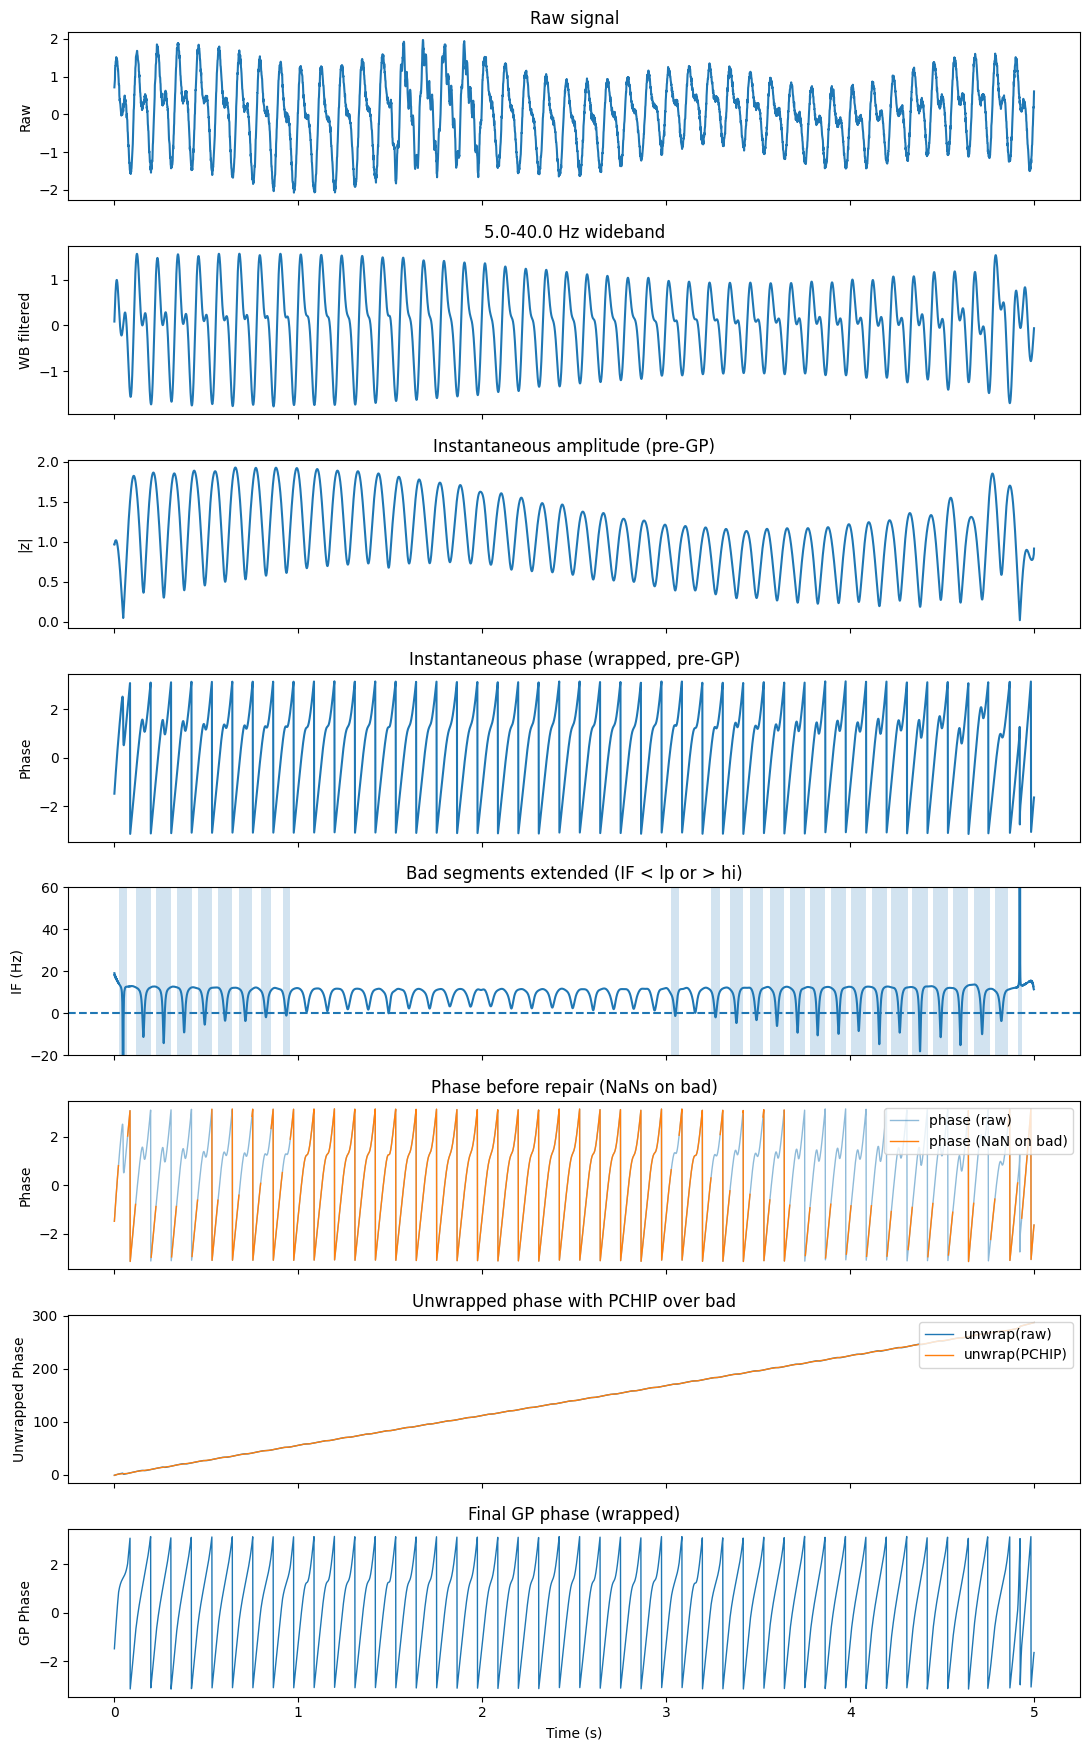

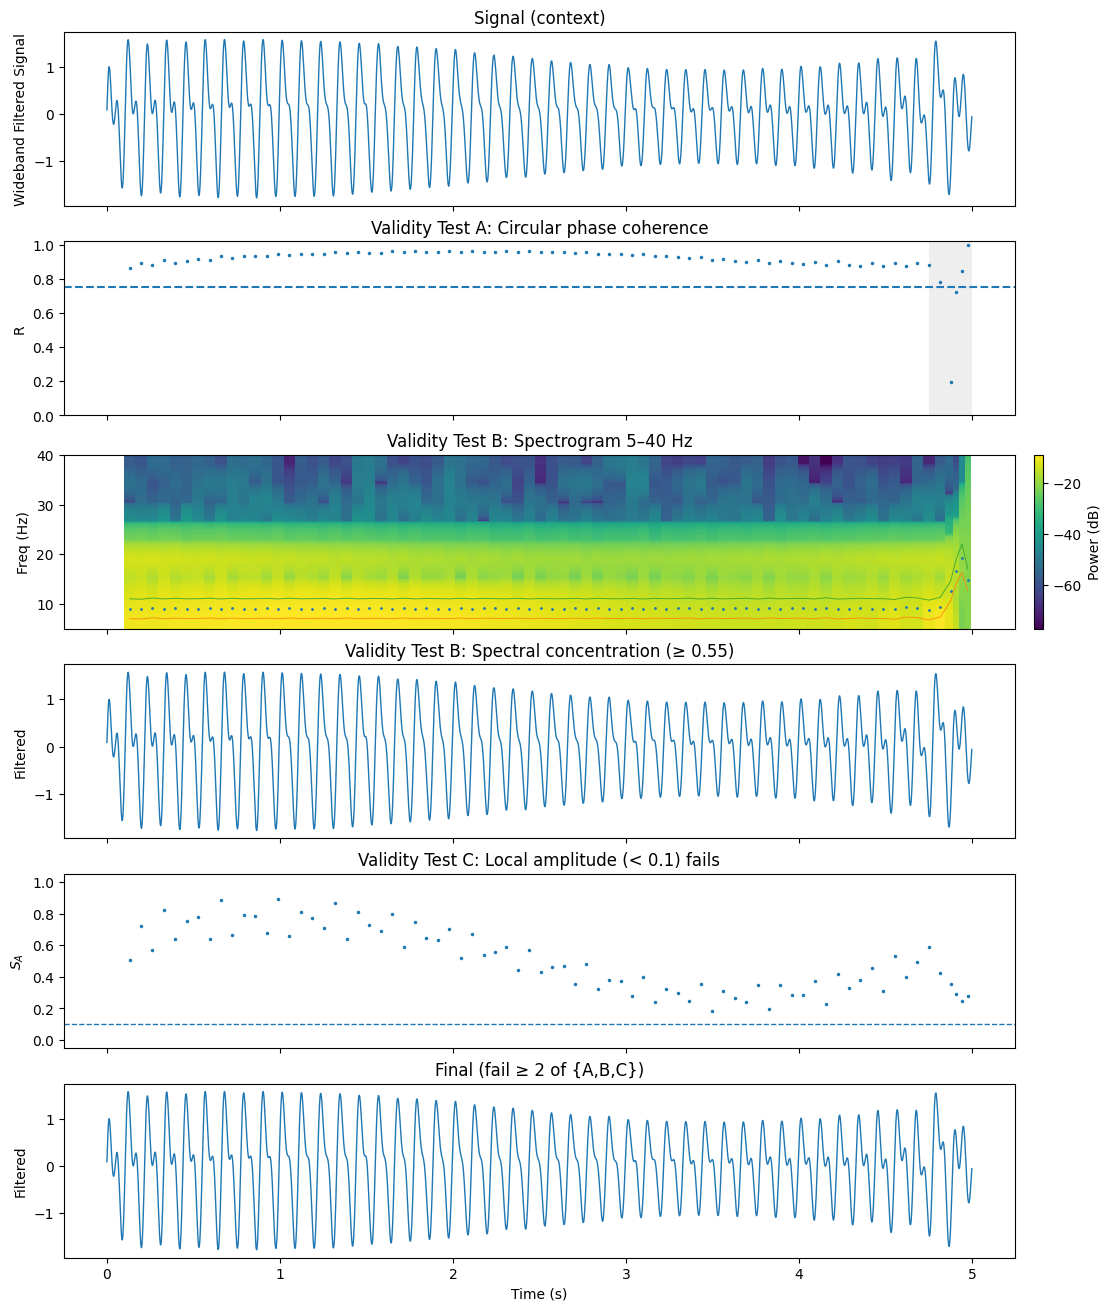

In [66]:
Fs = 1000
T=5.0
seed=2
rng = np.random.default_rng(seed)
t = np.arange(int(T*Fs)) / Fs
slow = 0.3 * np.sin(2*np.pi*0.7*t)
env1 = 1.0 + 0.3*np.sin(2*np.pi*0.2*t)
env2 = 0.6 + 0.2*np.cos(2*np.pi*0.15*t + 0.4)
s1 = env1 * np.sin(2*np.pi*9.0*t + 0.2)
s2 = env2 * np.sin(2*np.pi*18.0*t + 0.7)
riding = np.zeros_like(t)
burst = (t > 1.5) & (t < 2.0)
riding[burst] = 0.3*np.sin(2*np.pi*58.0*t[burst])
noise = 0.05 * rng.standard_normal(t.shape)
x = slow + s1 + s2 + riding + noise

_ = generalized_phase_1d(x, Fs, nwin=3, plot_validation=True, plot_gp=True)

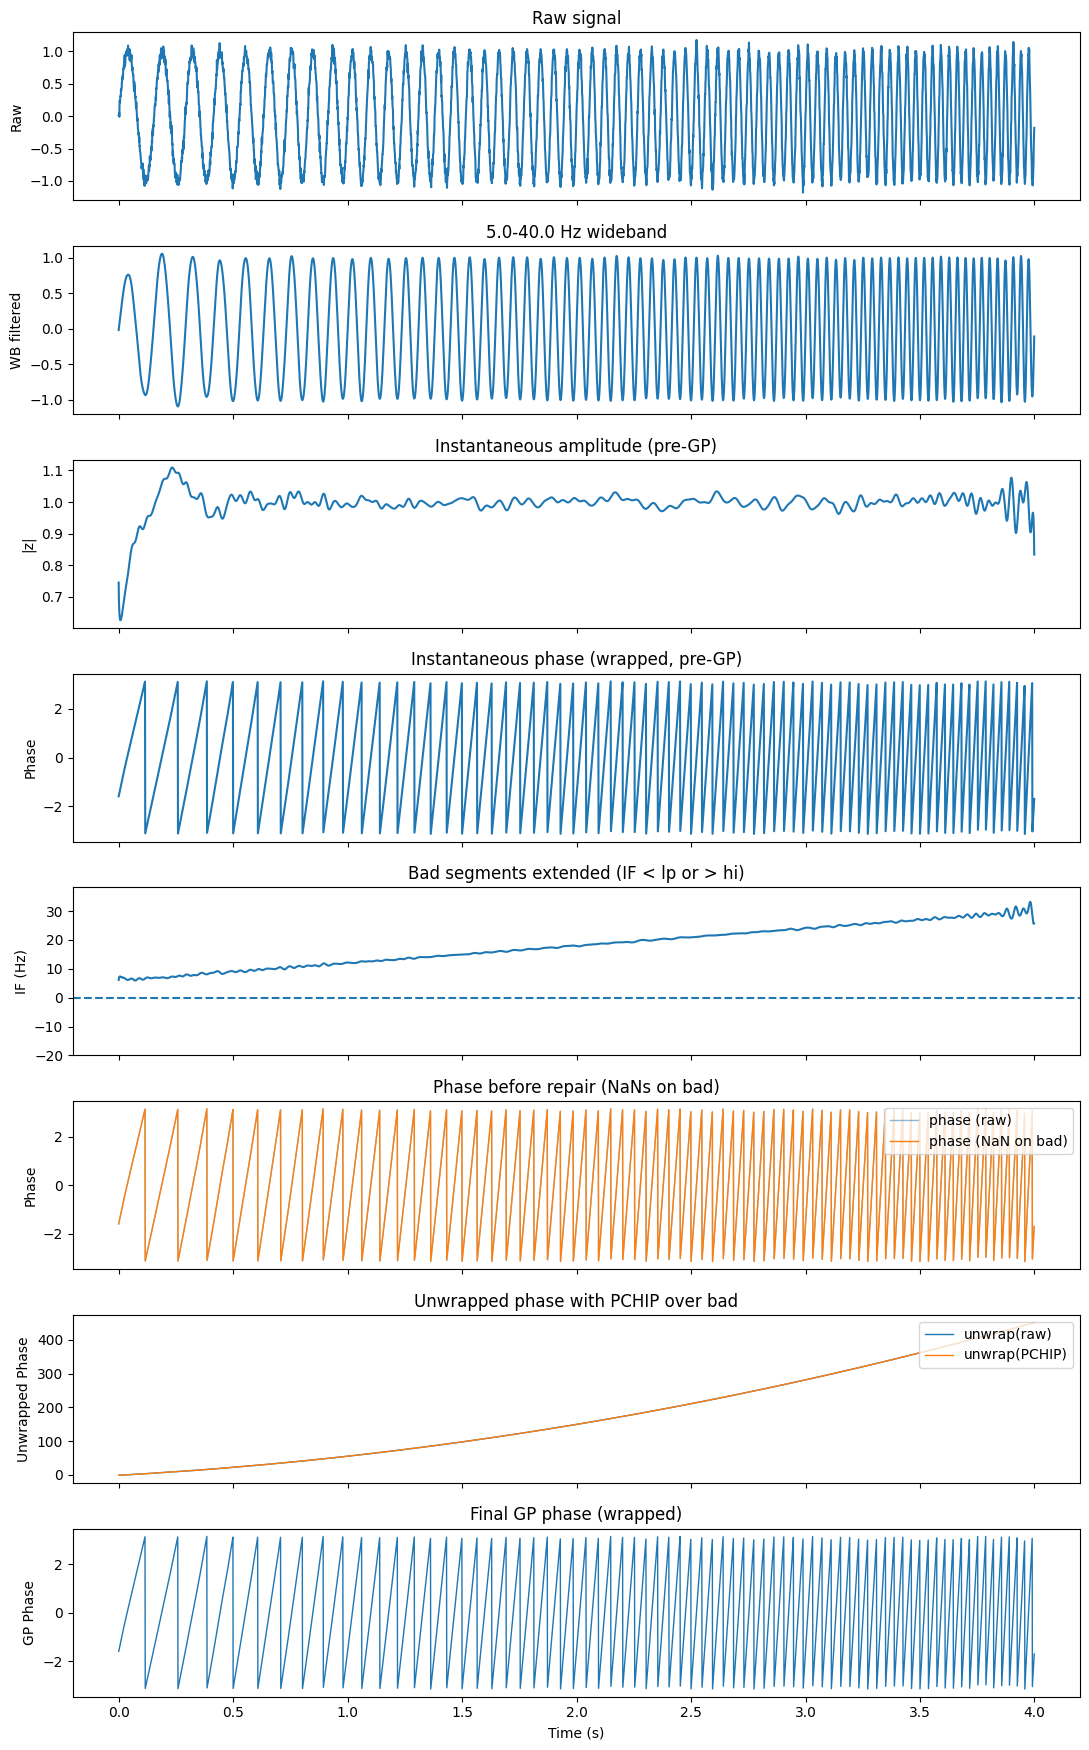

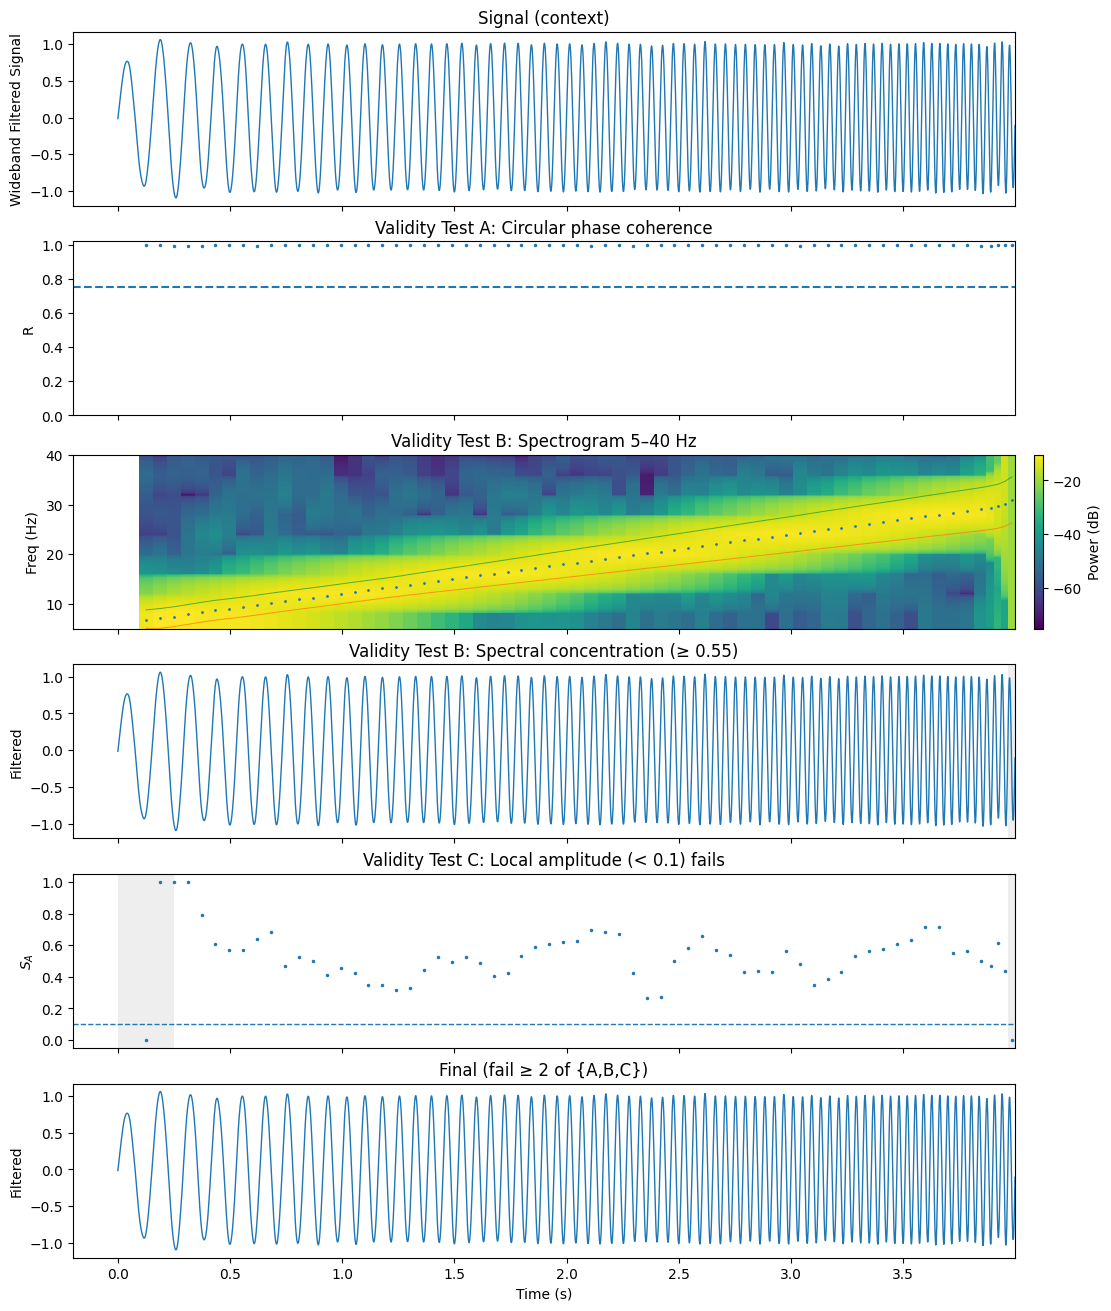

In [68]:
#Linear chirp (broadband, nonstationary frequency)
Fs = 1000
T = 4.0
t = np.arange(int(T*Fs)) / Fs
rng = np.random.default_rng(2)

# chirp from 6 Hz → 30 Hz across the window
f0, f1 = 6.0, 30.0
phase = 2*np.pi*(f0*t + 0.5*(f1-f0)*t**2/(T))
x = np.sin(phase) + 0.05*rng.standard_normal(t.shape)

_ = generalized_phase_1d(x, Fs, lo=5, hi=40, lp=0.0, nwin=3, plot_validation=True, plot_gp=True)

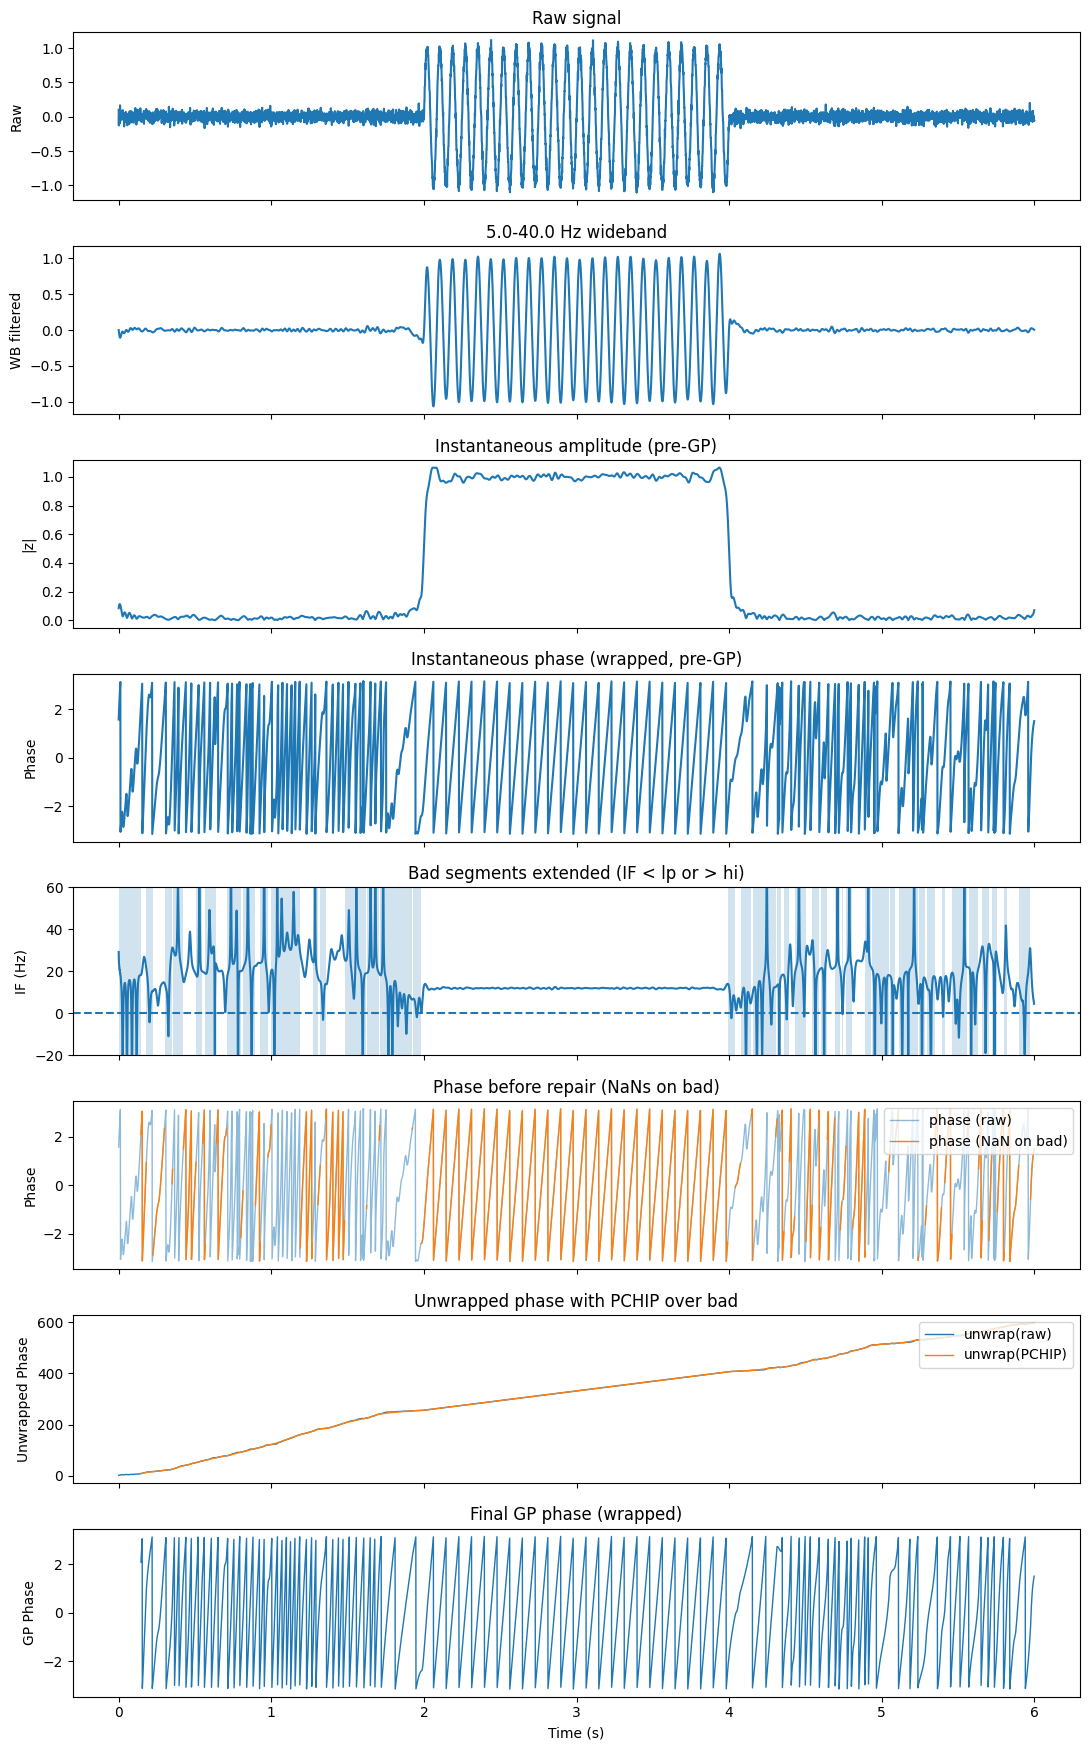

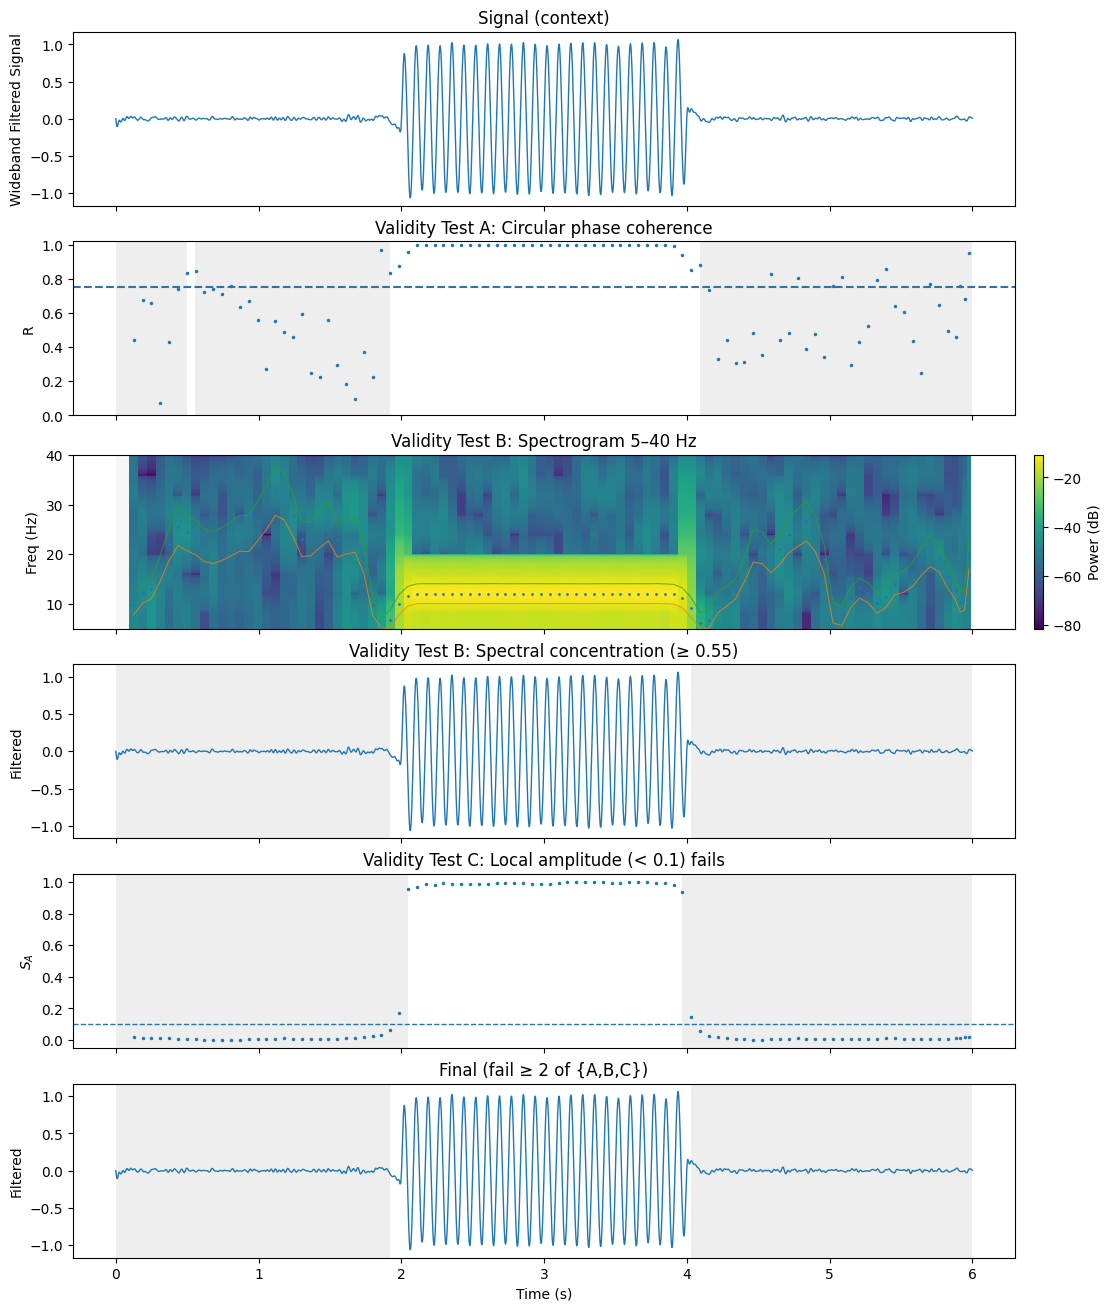

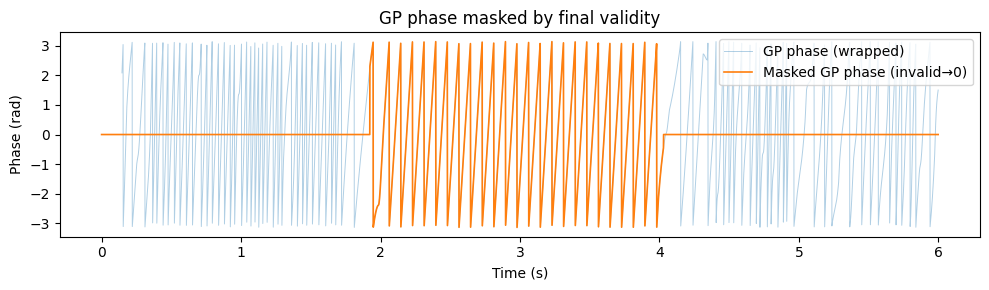

In [70]:
# Abrupt onset/offset (edge artifacts)
Fs = 1000
T = 6.0
t = np.arange(int(T*Fs)) / Fs
rng = np.random.default_rng(3)

x = np.zeros_like(t)
on = (t>=2.0) & (t<=4.0)
x[on] = np.sin(2*np.pi*12*t[on])
x += 0.05*rng.standard_normal(t.shape)

_ = generalized_phase_1d(x, Fs, lo=5, hi=40, lp=0.0, nwin=3, plot_validation=True, plot_gp=True, plot_masked_phase=True)

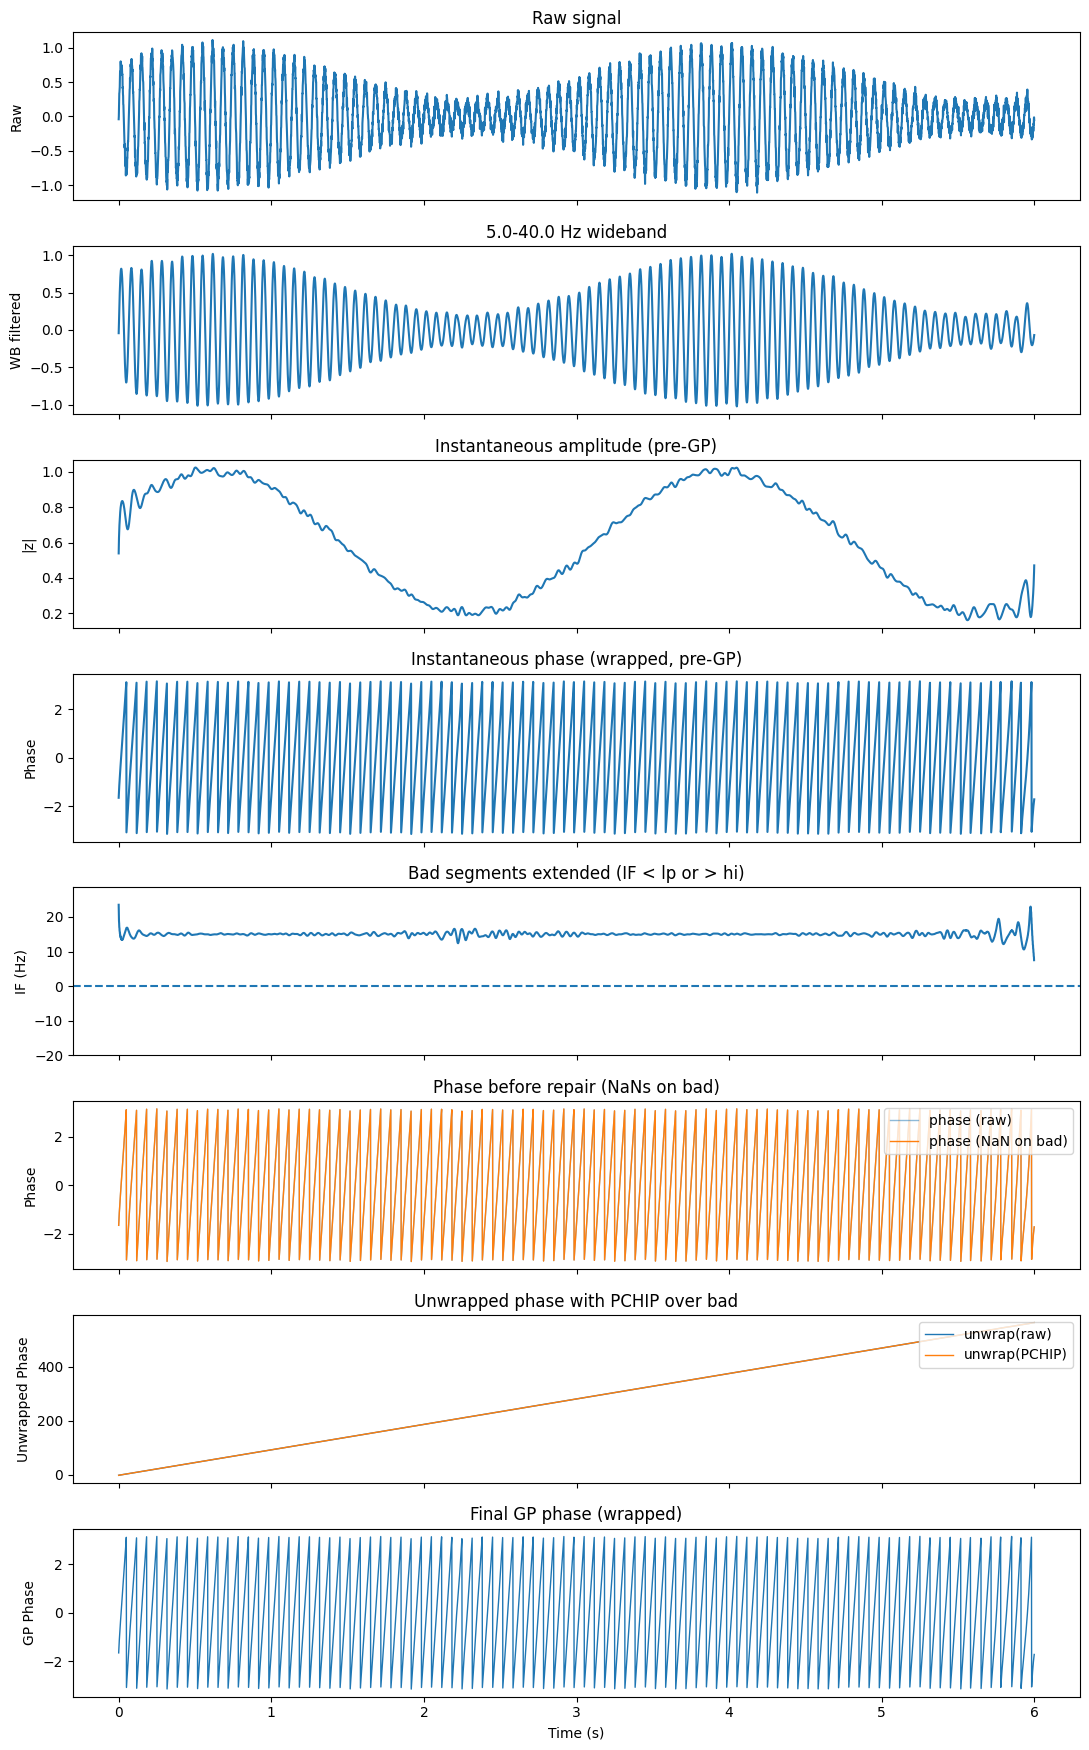

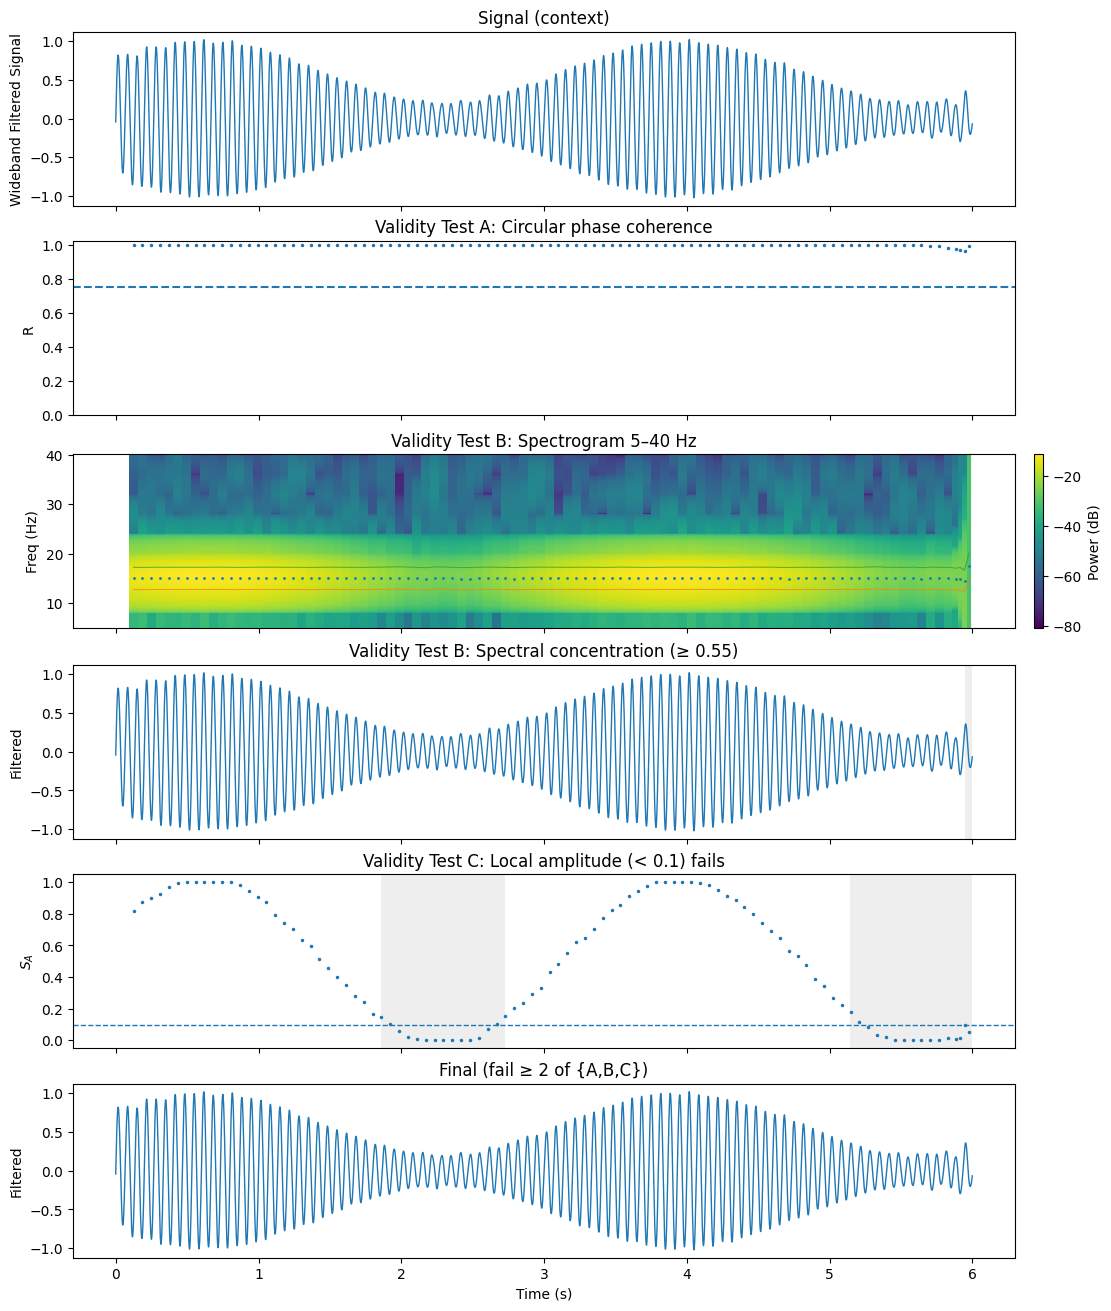

In [71]:
# Slow amplitude modulations (tests robustness to envelope changes)
Fs = 1000
T = 6.0
t = np.arange(int(T*Fs)) / Fs
rng = np.random.default_rng(5)

env = 0.6 + 0.4*np.sin(2*np.pi*0.3*t + 0.4)       # slow AM
x = env * np.sin(2*np.pi*15*t) + 0.05*rng.standard_normal(t.shape)

_ = generalized_phase_1d(x, Fs, lo=5, hi=40, lp=0.0, nwin=3, plot_validation=True, plot_gp=True)

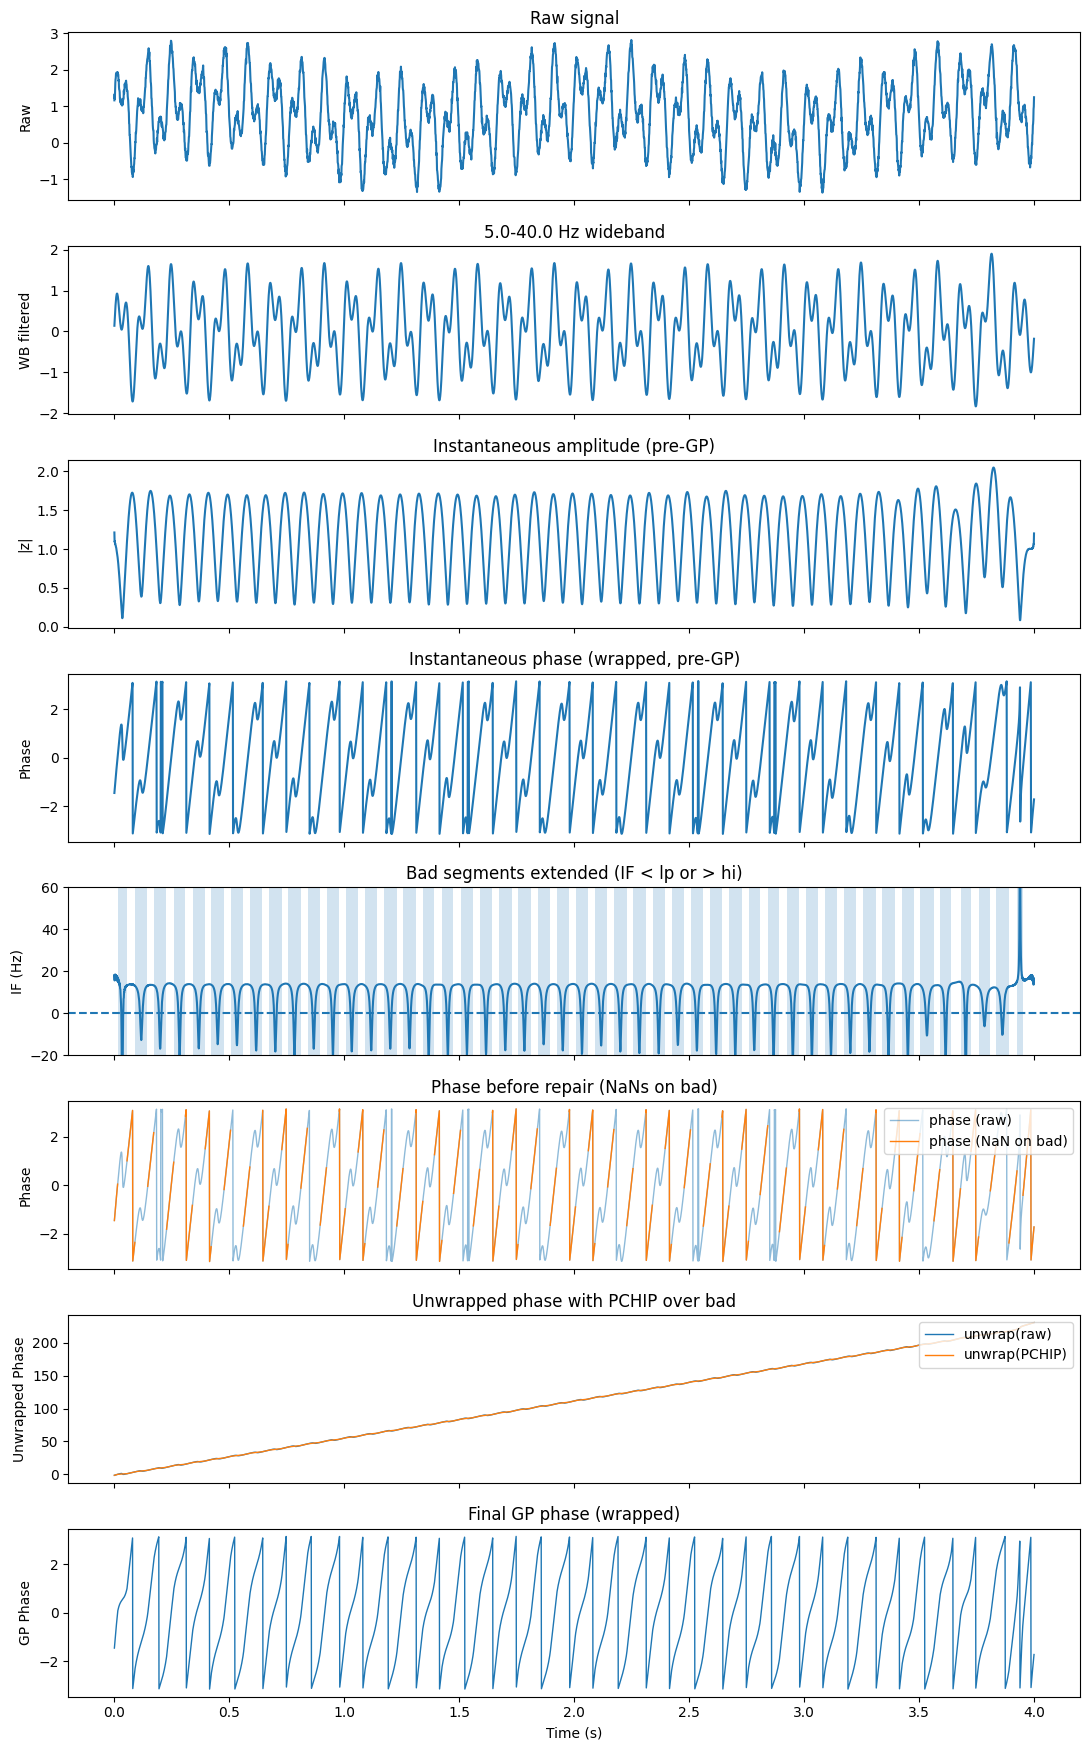

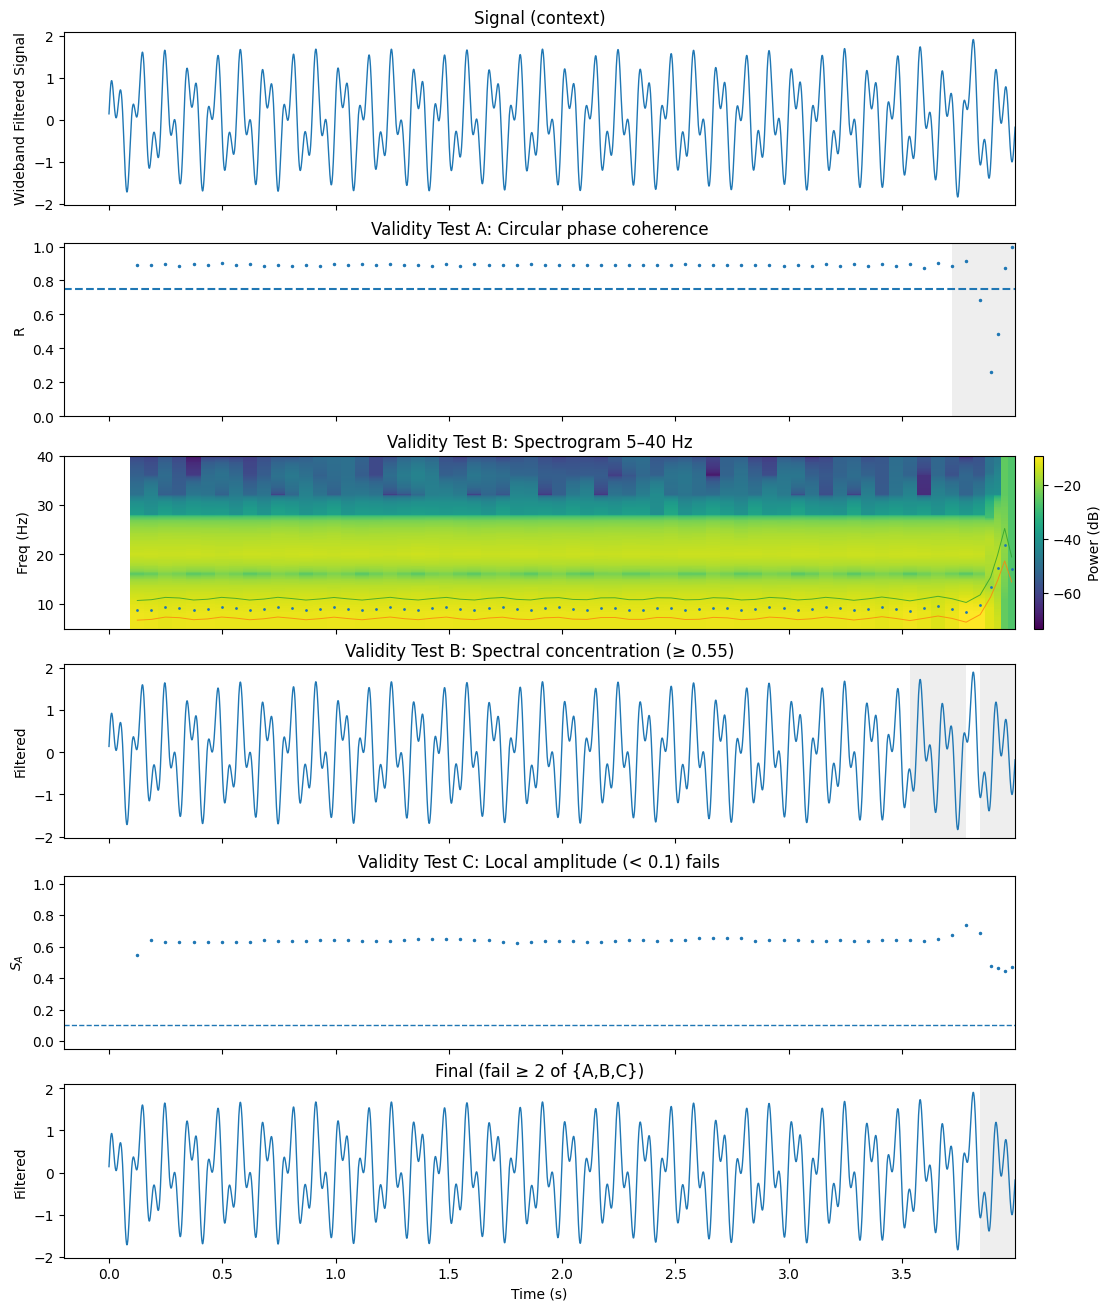

In [72]:
# DC offset + drift + multiple components (tests filter + phase stability)
Fs = 1000
T = 4.0
t = np.arange(int(T*Fs)) / Fs
rng = np.random.default_rng(6)

dc = 0.7
drift = 0.4*np.sin(2*np.pi*0.6*t)
multi = np.sin(2*np.pi*9*t) + 0.7*np.sin(2*np.pi*21*t + 0.6)
noise = 0.06*rng.standard_normal(t.shape)
x = dc + drift + multi + noise

_ = generalized_phase_1d(x, Fs, lo=5, hi=40, lp=0.0, nwin=2, plot_validation=True, plot_gp=True)

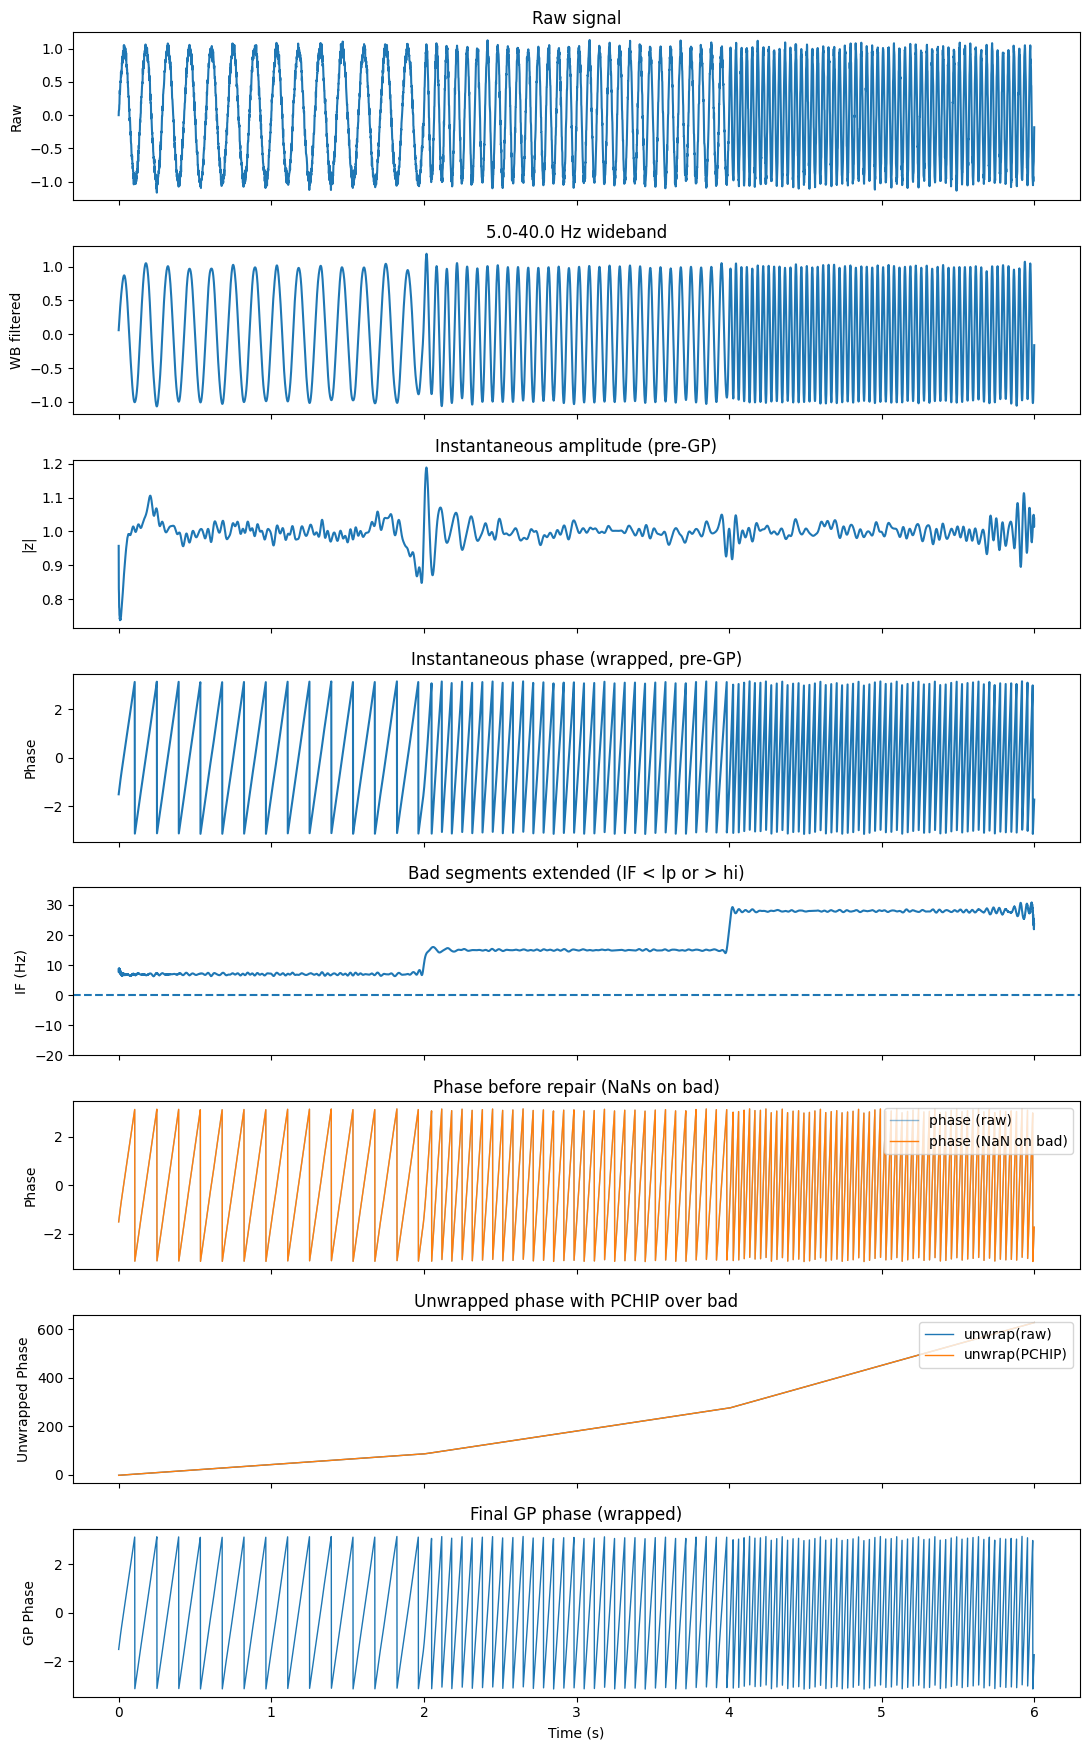

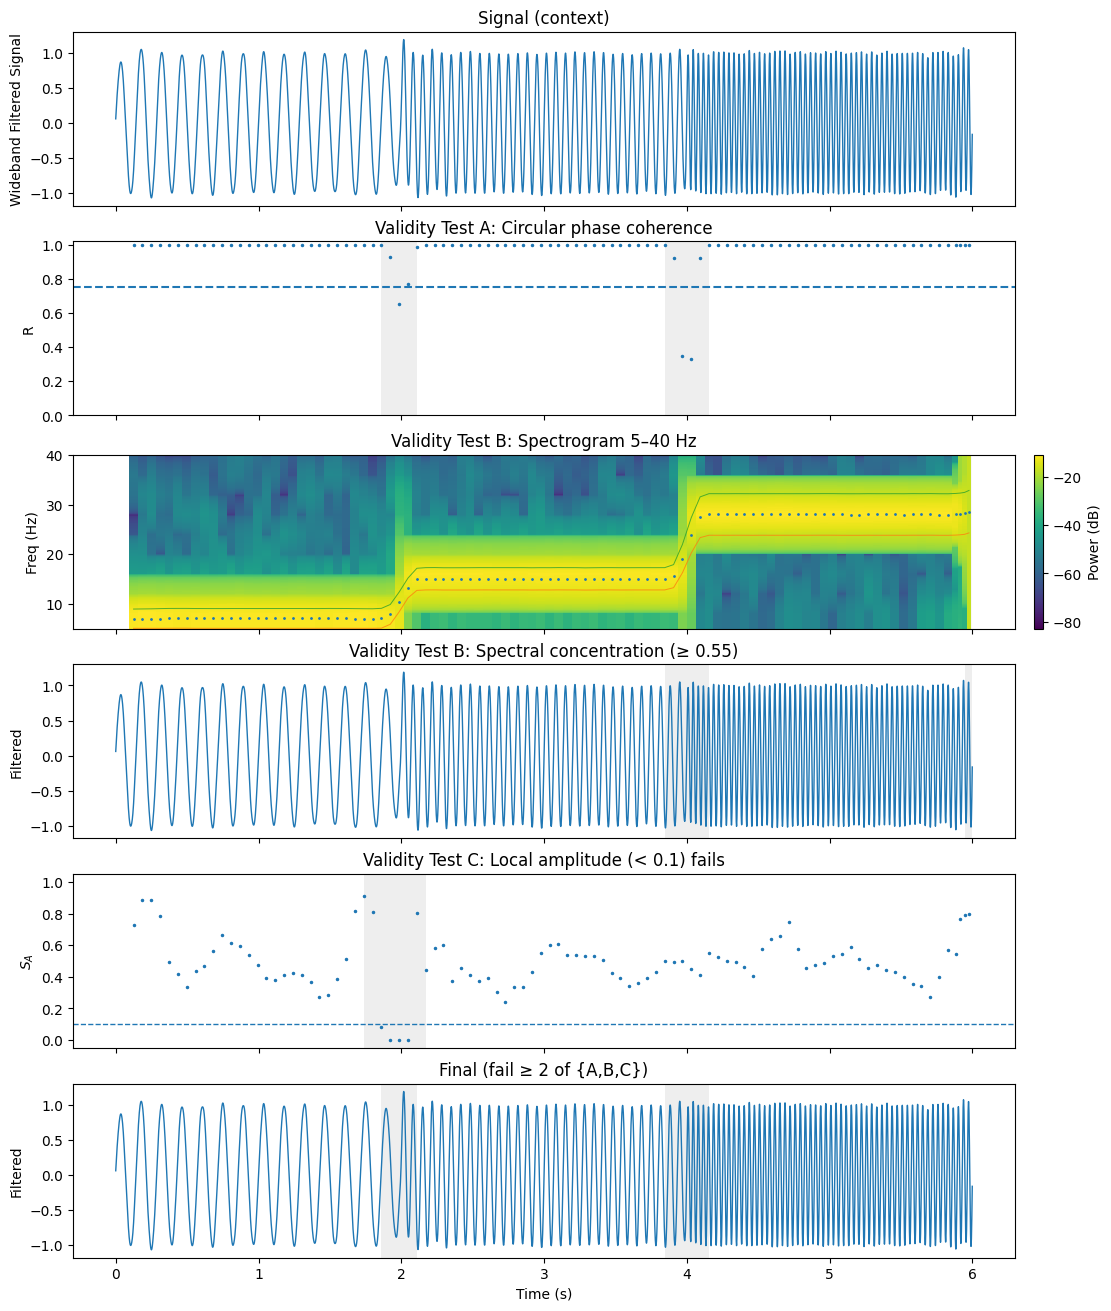

In [73]:
# Frequency switching (piecewise constant frequency; tests IF steps)
Fs = 1000
T = 6.0
t = np.arange(int(T*Fs)) / Fs
rng = np.random.default_rng(7)

x = np.zeros_like(t)
seg = int(len(t)/3)
x[:seg] = np.sin(2*np.pi*7*t[:seg])
x[seg:2*seg] = np.sin(2*np.pi*15*t[seg:2*seg])
x[2*seg:] = np.sin(2*np.pi*28*t[2*seg:])
x += 0.05*rng.standard_normal(t.shape)

_ = generalized_phase_1d(x, Fs, lo=5, hi=40, lp=0.0, nwin=3, plot_validation=True, plot_gp=True)

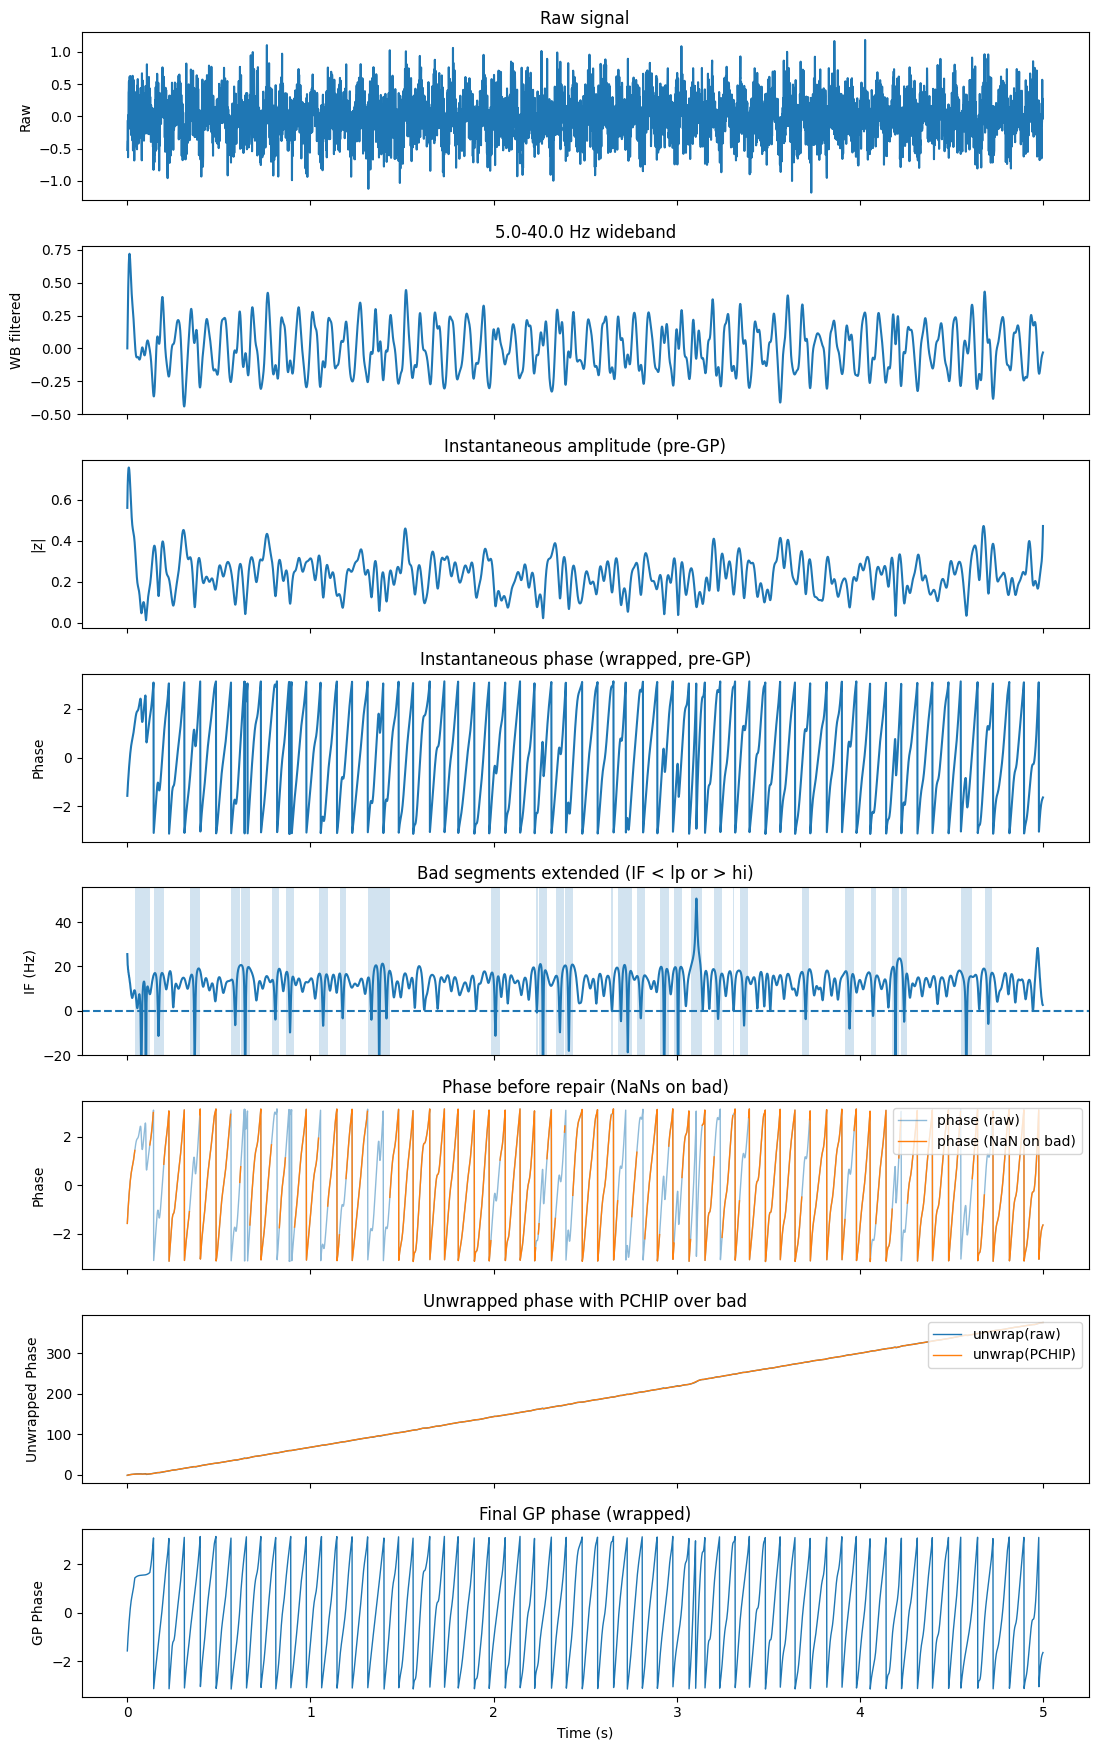

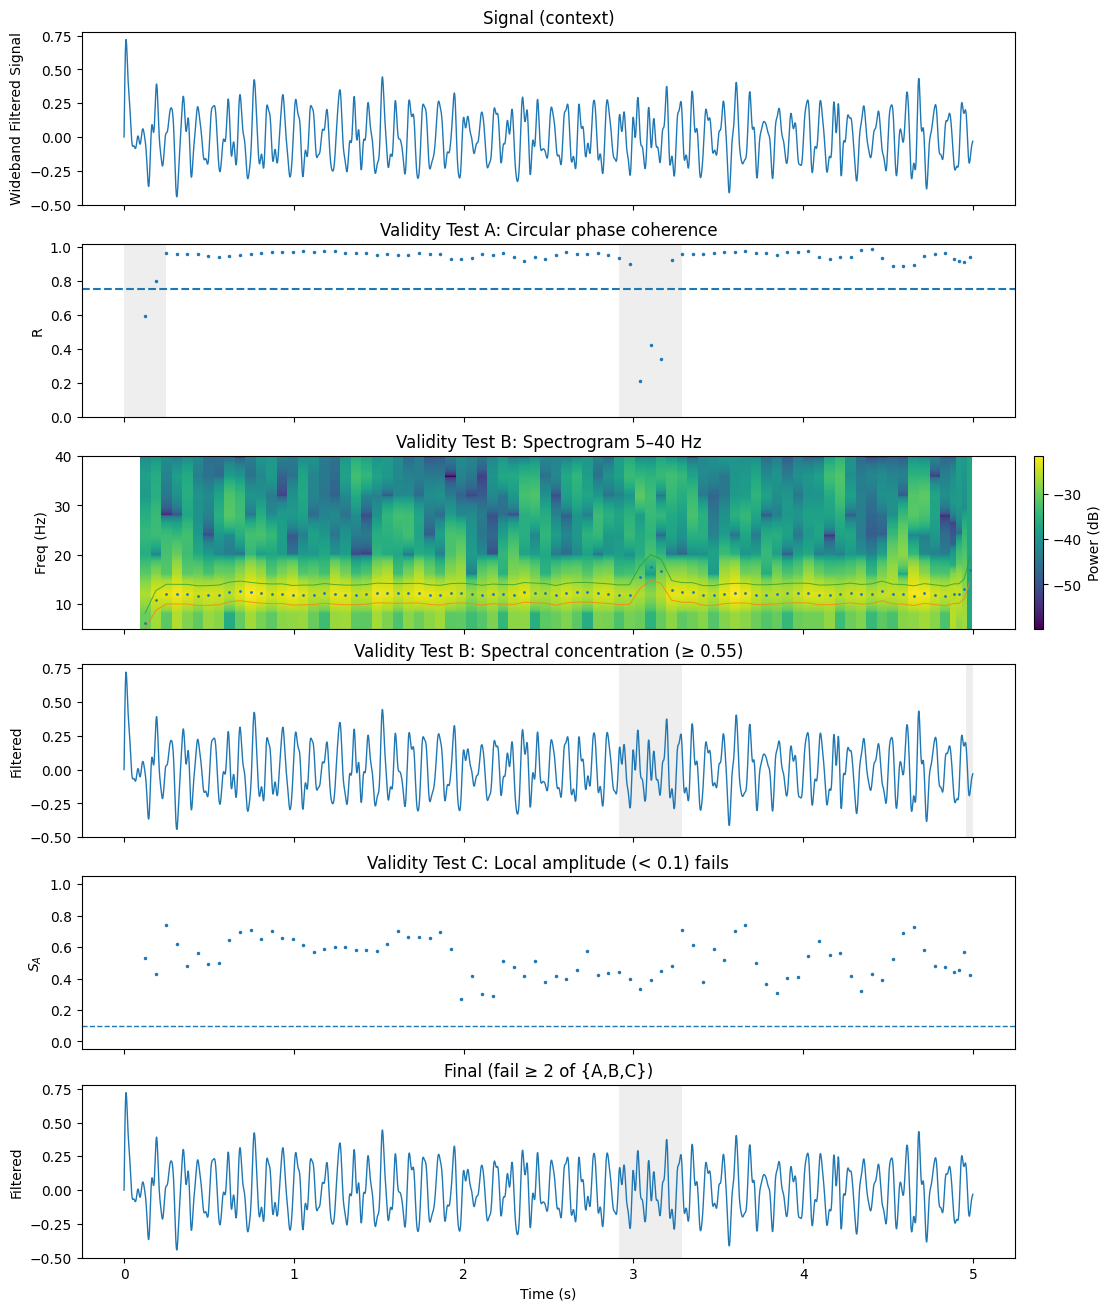

In [74]:
# Very low SNR (tests failure modes; expect many “bad” segments if lp>0)
Fs = 1000
T = 5.0
t = np.arange(int(T*Fs)) / Fs
rng = np.random.default_rng(8)

signal = 0.2*np.sin(2*np.pi*12*t)
noise = 0.3*rng.standard_normal(t.shape)
x = signal + noise

# try lp=0 first; then try lp=1.0 to see more aggressive stitching
_ = generalized_phase_1d(x, Fs, lo=5, hi=40, lp=0.0, nwin=3, plot_validation=True, plot_gp=True)

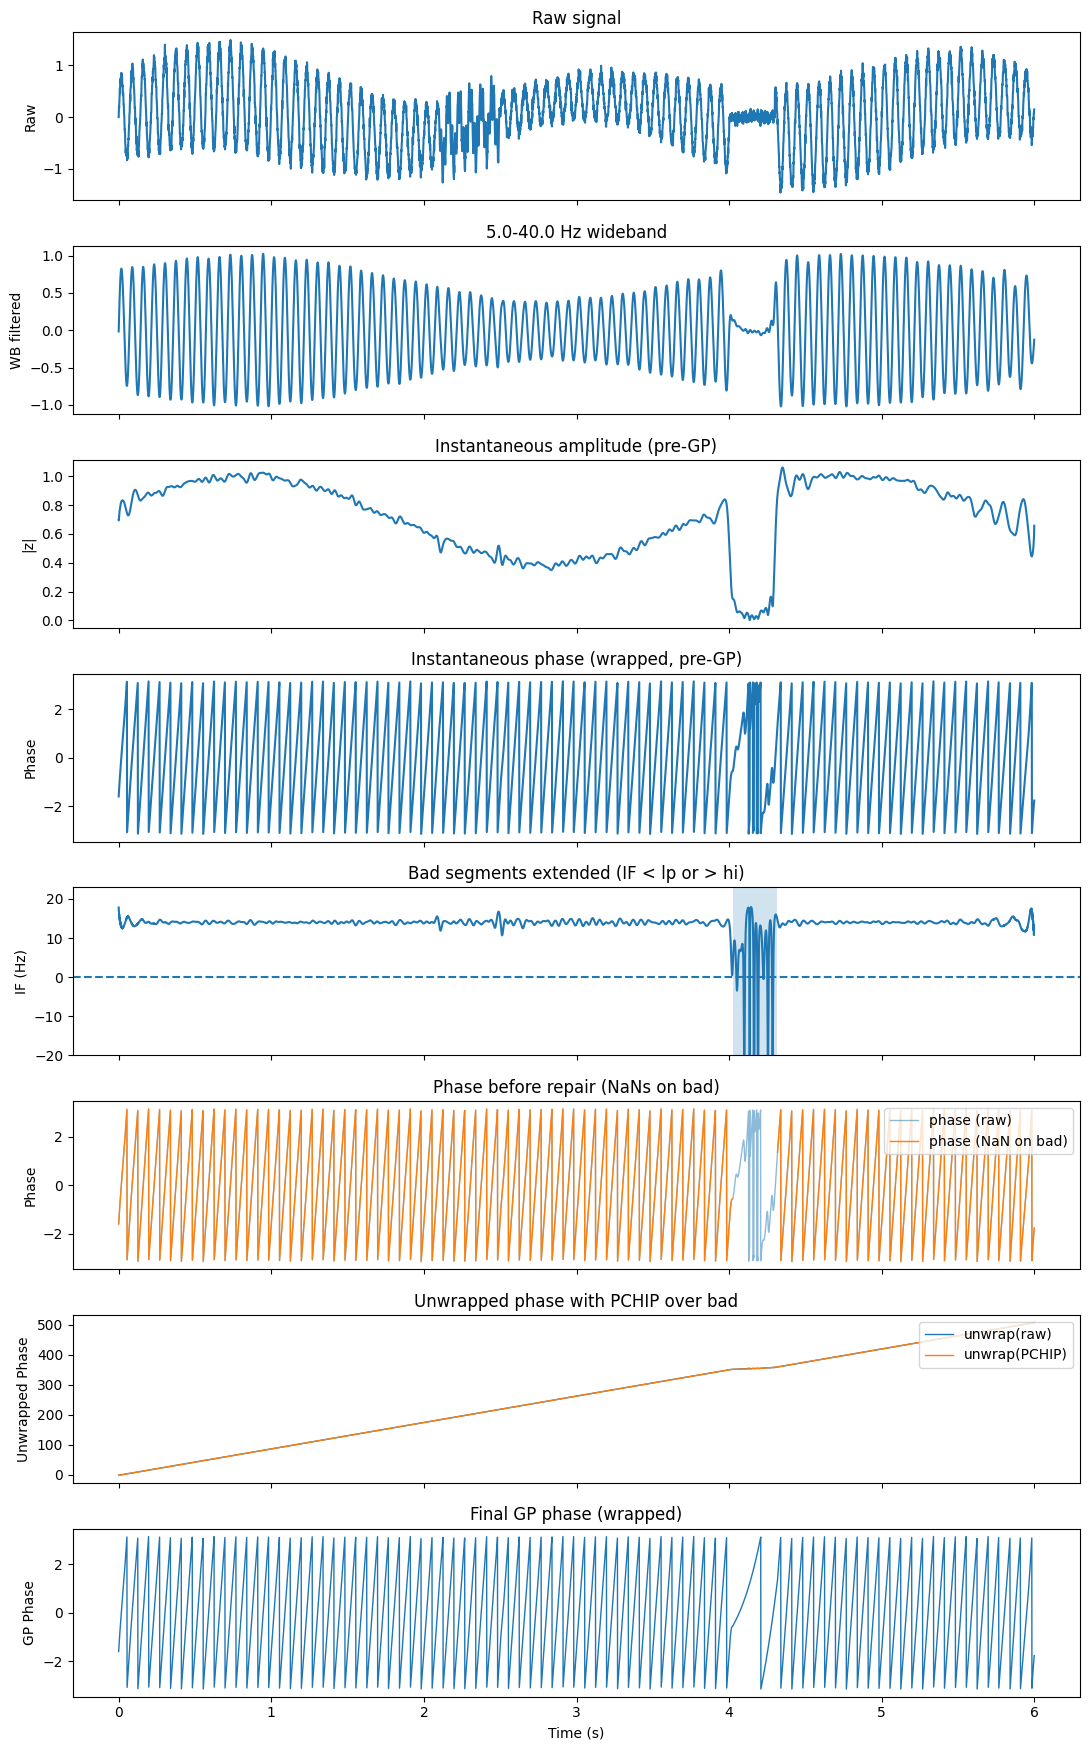

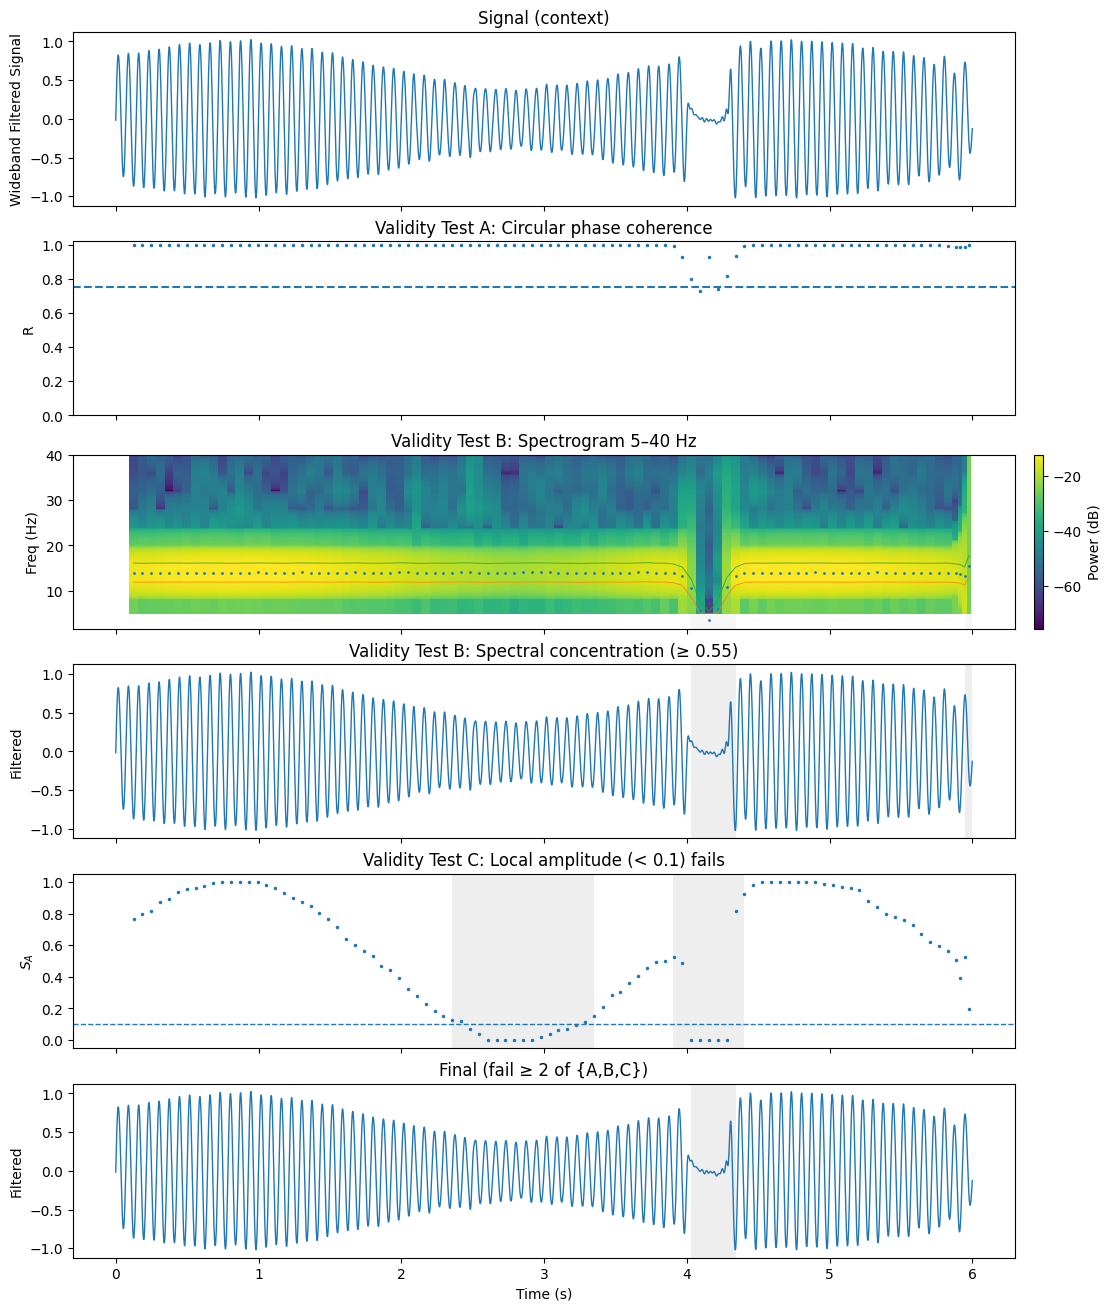

In [83]:
# Mixed: drift + AM + riding + brief dropout (NaNs)
Fs = 1000
T = 6.0
t = np.arange(int(T*Fs)) / Fs
rng = np.random.default_rng(11)

drift = 0.4*np.sin(2*np.pi*0.4*t)
env  = 0.7 + 0.3*np.sin(2*np.pi*0.25*t+0.3)
base = env*np.sin(2*np.pi*14*t)

rider = np.zeros_like(t)
mask_r = (t>2.1) & (t<2.5)
rider[mask_r] = 0.35*np.sin(2*np.pi*55*t[mask_r])

drop = np.ones_like(t)
mask_d = (t>4.0) & (t<4.3)
drop[mask_d] = 0.0                                # brief signal loss (zeros)
# (if you want NaNs instead: make x first, then set x[mask_d]=np.nan and handle/filter accordingly)

noise = 0.06*rng.standard_normal(t.shape)
x = drop*(drift + base + rider) + noise

_ = generalized_phase_1d(x, Fs, lo=5, hi=40, lp=0.0, nwin=3, plot_validation=True, plot_gp=True)

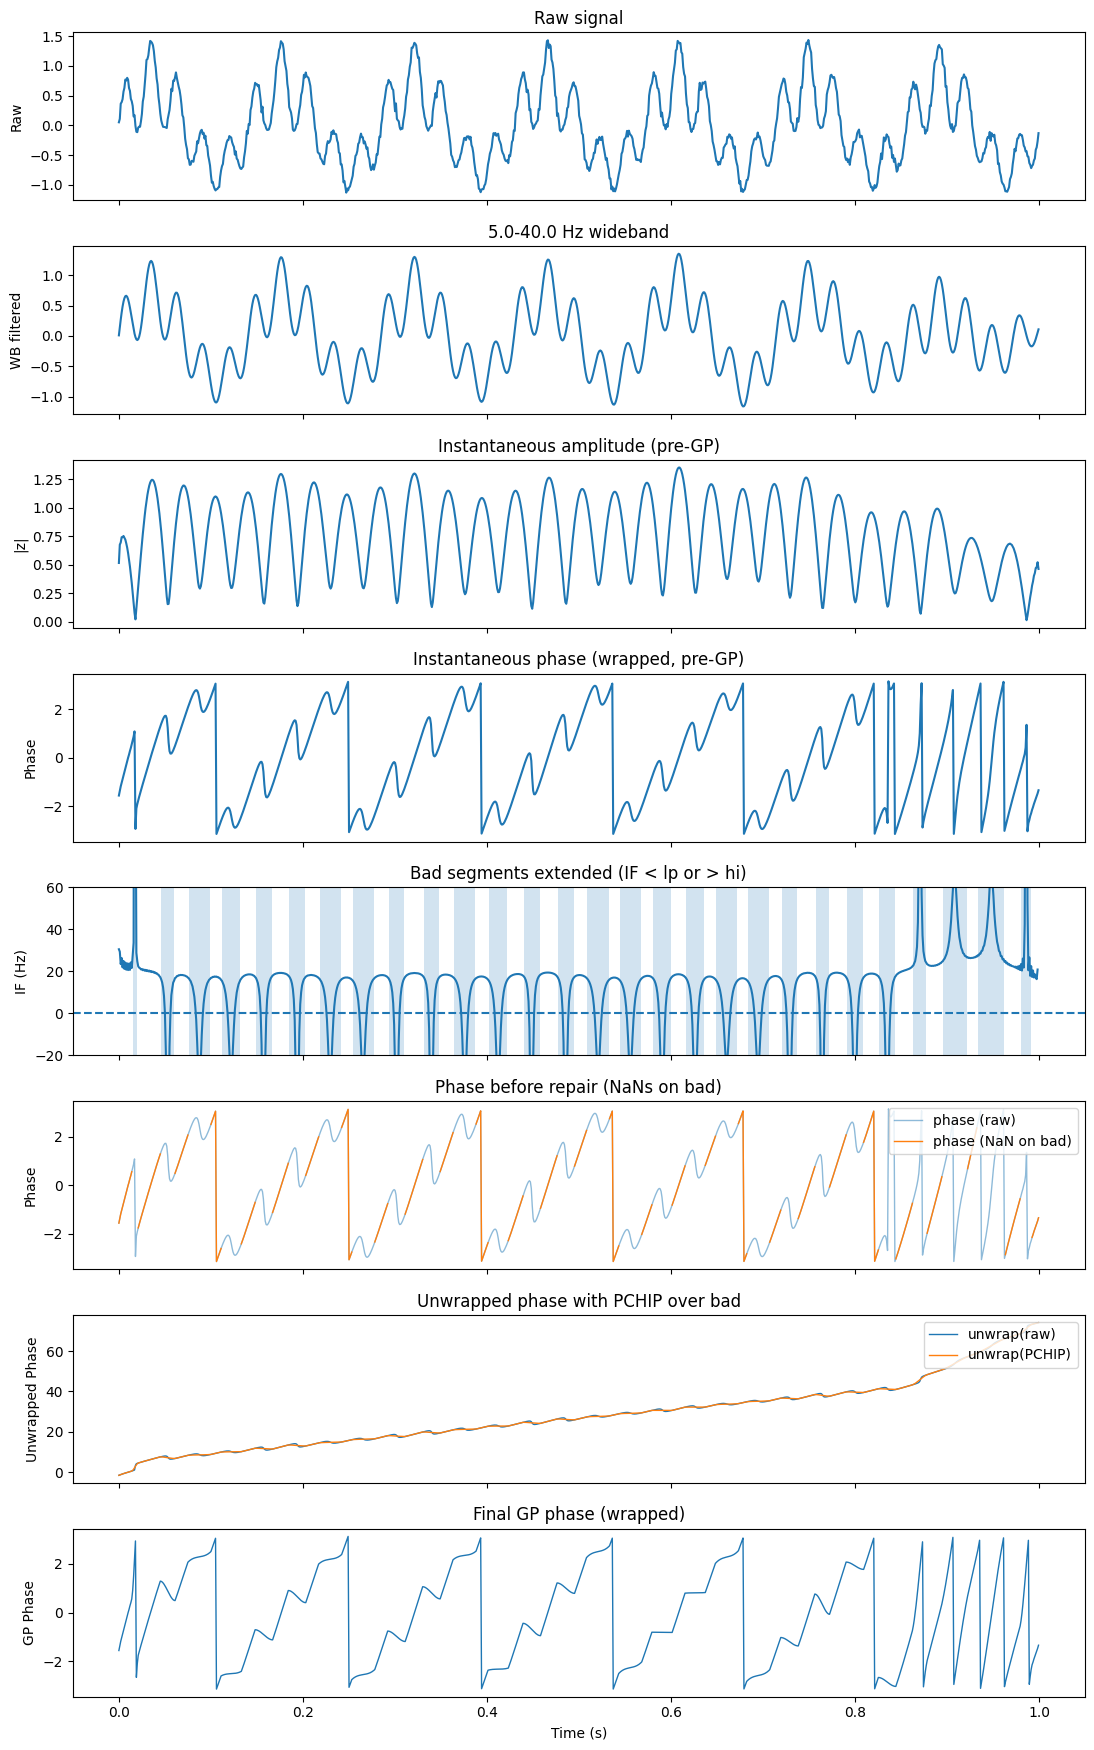

In [121]:
# --- timebase ---
Fs = 1000          # Hz
T  = 1.0           # seconds
t  = np.linspace(0, T, int(Fs*T), endpoint=False)

# --- components ---
f_lf = 7.0         # low-frequency (envelope / centerline) Hz
f_hf = 35.0        # high-frequency carrier Hz

lf = np.sin(2*np.pi*f_lf*t)

# Centerline modulation: HF rides "on top of" the LF wave
# c_strength scales how much the HF's midpoint follows the LF.
def centerline(lf, c_strength):
    return c_strength * lf

# Amplitude modulation: HF has highest amplitude at LF peaks, lowest at LF troughs
# We map lf in [-1,1] --> envelope in [a_min, a_max], optionally biasing with a power gamma.
def envelope(lf, a_min, a_max, gamma=1.0):
    u = (lf + 1.0) * 0.5          # map to [0,1]
    u = u**gamma                  # sharpen peaks if gamma>1
    return a_min + (a_max - a_min)*u

# Build three variants
# 1) Light modulation
c1 = centerline(lf, c_strength=2)
e1 = envelope(lf, a_min=0, a_max=1, gamma=5.0)
sig1 = c1 + e1 * np.sin(2*np.pi*f_hf*t)

# 2) Moderate modulation
c2 = centerline(lf, c_strength=2)
e2 = envelope(lf, a_min=0.2, a_max=1.1, gamma=1.25)
sig2 = c2 + e2 * np.sin(2*np.pi*f_hf*t)

# 3) Strong modulation + slight irregularity
c3 = centerline(lf, c_strength=0.7)
e3 = envelope(lf, a_min=0.4, a_max=0.7, gamma=2)
# small random phase jitter to make peaks less uniform
rng = np.random.default_rng(42)
phase_jitter = 0.5*np.sin(2*np.pi*1.5*t) + 0.1*rng.standard_normal(t.shape)
sig3 = c3 + e3 * np.sin(2*np.pi*f_hf*t + phase_jitter)

# Optional: tiny measurement noise (comment out if you want perfectly clean)
noise_level = 0.03
sig1 += noise_level*rng.standard_normal(sig1.shape)
sig2 += noise_level*rng.standard_normal(sig2.shape)
sig3 += noise_level*rng.standard_normal(sig3.shape)


_ = generalized_phase_1d(sig3, Fs, lo=5, hi=40, lp=0.0, nwin=1, plot_gp=True)
